In [1]:
library(readxl)
library(vegan)
library(ggplot2)
library(SRS)
library(tidyverse)
library(divermeta)
library(kableExtra)
library(FSA)
library(latex2exp)
library(cowplot)
library(patchwork)
library(gridExtra)
library(pheatmap)
library(multcompView)

source("utils/general_functions.R")

Loading required package: permute

Loading required package: shiny

Loading required package: DT


Attaching package: ‘DT’


The following objects are masked from ‘package:shiny’:

    dataTableOutput, renderDataTable


Loading required package: shinycssloaders

Loading required package: shinybusy

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ purrr     1.1.0     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows


## FSA v0.10.0. See citation('FSA') if used in publication.
## Run fishR() for related websit

In [2]:


# Define the file path and sheet name
file_path <- "LUCAS/LUCAS_ARGs_for_Multiplicity.xlsx"
sheet_name <- "ARGs_hierarchy"

depth_file <- "LUCAS/seq_depth.xlsx" 

# Read data from line 4 to 64
df_clust <- read_excel(path = file_path, sheet = sheet_name)

df_meta <- read_excel(path = file_path, sheet = "Sample_metadata")

df_depth <- read_excel(path = depth_file) 


levels <- c("Gene", "Family", "Subclass", "Class")
sheets <- c("Gene" = "ARGs_abund_Gene", 'Family' = "ARGs_abund_Family", "Subclass" = "ARG_abund_Subclass", "Class" = "ARG_abund_Class")


l1 <- "Gene"
l2 <- "Subclass"

df_ab <- read_excel(path = file_path, sheet = sheets[l1])


In [3]:
# Computes the missing reads for each sample
df_temp <- df_ab %>% select(SampleID)
tot <- rowSums(df_ab %>% select(-SampleID))

df_temp["actual"] <- tot 

df_depth <- inner_join(df_depth, df_temp, by = "SampleID")

df_depth["missing"] <- df_depth$Total_functional_reads - df_depth$actual


# Adds the mssing
df_ab <- inner_join(df_ab, df_depth %>% select(SampleID, missing), by = "SampleID")


min_depth <- df_depth %>% filter(Total_functional_reads > 100)
min_depth <- min(min_depth$Total_functional_reads)
min_depth

[1] 4670232

In [4]:

df_filtered_ab <- df_ab %>% 
  inner_join(df_depth %>% filter(Total_functional_reads >= min_depth) %>% select(SampleID), by = "SampleID")

df_filtered_ab

SampleID,AAC(2')-I,AAC(2')-IE,AAC(2')-IIB,AAC(3)-I,AAC(3)-IB-AAC(6')-IB,AAC(3)-II,AAC(3)-IIIA,AAC(3)-IV,AAC(3)-IX,⋯,VEB-7,VGAA,VGAC,VGAD,VGAE,VIM,VIOMYCIN_PHOSPHOTRANSFERASE,YKKC,YOJI,missing
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
L0001,6,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,11738528
L0002,0,0,0,0,0,0,2,4,0,⋯,0,0,0,0,0,0,0,0,0,10617794
L0003,6,0,0,2,0,0,2,6,0,⋯,0,0,0,0,0,0,0,0,2,9720662
L0004,16,0,0,4,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,10758024
L0005,0,0,0,6,0,0,6,0,0,⋯,0,0,0,0,0,0,0,0,0,12627184
L0006,4,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,11366756
L0007,14,0,0,0,0,0,4,0,0,⋯,0,0,0,0,0,0,0,0,0,10769358
L0008,10,0,0,8,0,0,2,0,0,⋯,0,0,0,0,0,0,0,0,0,10872880
L0009,2,0,0,8,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,13510996


## SRS

In [5]:
set.seed(1)

otus <- colnames(df_filtered_ab  %>% select(-SampleID))
samples_ids  <- df_filtered_ab$SampleID

# sets up the structure
df_normalized  <-  as_tibble(t(df_filtered_ab  %>% select(-SampleID)))
colnames(df_normalized)  <- samples_ids
# Normalizes
normalized <- SRS(df_normalized, min_depth)
sample_ids <- colnames(normalized)

# Returns to the structure
df_normalized  <- as_tibble(t(normalized))
colnames(df_normalized)  <- otus
df_normalized <- cbind(data.frame(SampleID = sample_ids), df_normalized)

# Removes the Missing
df_normalized  <-  df_normalized  %>%  select(-missing)

nrow(df_normalized)

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if
`.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.”


[1] 657

## Multiplicity and Diversity

In [6]:
mul <- c()
div <- c()



# Iterates over each row
for(sample in df_normalized$SampleID)
{
    df_ab_sample <- df_normalized[df_normalized$SampleID == sample,]
    genes <- colnames(df_ab_sample)
    df_ab_sample <- data.frame(t(df_ab_sample))
    df_ab_sample["Gene"] <-genes
    colnames(df_ab_sample) <- c("abundance", "Gene")
    df_ab_sample <- df_ab_sample[-1,]

    df_ab_sample <- inner_join(df_ab_sample, df_clust[,c("Gene", l2)], by ="Gene")
    df_ab_sample$abundance = as.integer(df_ab_sample$abundance)
    df_ab_sample <- df_ab_sample[df_ab_sample$abundance > 0,]

    ab = df_ab_sample$abundance
    clust = df_ab_sample[[l2]]
    
    # Post Clust
    ab_clust_sample <- tapply(ab, clust, sum)
    p_clust = ab_clust_sample /sum(ab_clust_sample)
    div_clust <- exp(-sum(p_clust*log(p_clust)))
    
    div <- c(div, div_clust) 
    mul <- c(mul, multiplicity.inventory(ab, clust))

}


## Kruskal-Wallis Test


In [9]:


set.seed(1)

# Short Label Order
short_label_order = c("WC", "WD", "Gr", "Cr")
label_order = c("woodland_coniferous", "woodland_deciduous", "grassland", "cropland")

# Prepare dataframe
df_analysis <- data.frame(SampleID = df_filtered_ab$SampleID, div = div, mul = mul)
df_analysis <- inner_join(df_analysis, df_meta, by = "SampleID")

multiplicity_col <- "mul"
diversity_col <- "div"
group_col <- "LandCover"

multiplicity_name <- "Inventory Multiplicity $^1M$"
diversity_name <- "Diversity $^1D$"
group_name <- "Habitat Type"

kw_caption <- "Kruskal-Wallis test results for diversity ($^1D$) and inventory multiplicity ($^1M$) comparing the different habitat type"
dun_caption <- "Dunn's Test Results for diversity ($^1D$) and inventory multiplicity ($^1M$) comparing the different habitat type"

      
kw_label <- "tab:kw_results_antibiotics"
dunn_label <- "tab:dunn_results_antibiotics"



tests_resp <- kw_and_dunn_test(
        df_test = df_analysis,
        order = label_order,
        labels = short_label_order, 
        multiplicity_col = multiplicity_col,
        diversity_col = diversity_col,
        group_col = group_col,
        diversity_name = diversity_name,
        group_name = group_name,
        multiplicity_name = multiplicity_name,
        kw_caption = kw_caption,
        dun_caption = dun_caption,
        kw_label = kw_label,
        dunn_label = dunn_label
      )


cat(tests_resp$kw_table)
cat("\n\n")
cat(tests_resp$dunn_table)




\begin{table}[!h]
\centering
\caption{Kruskal-Wallis test results for diversity ($^1D$) and inventory multiplicity ($^1M$) comparing the different habitat type}
\centering
\begin{tabular}[t]{lrrl}
\toprule
Metric & $\chi^2$ & df & p-val\\
\midrule
Diversity $^1D$ & 107.9979 & 3 & 0.0001 ***\\
Inventory Multiplicity $^1M$ & 213.7223 & 3 & 0.0001 ***\\
\bottomrule
\end{tabular}
\label{tab:kw_results_antibiotics}
\end{table}

\begin{table}[!h]
\centering
\caption{Dunn's Test Results for diversity ($^1D$) and inventory multiplicity ($^1M$) comparing the different habitat type}
\centering
\begin{tabular}[t]{lllllll}
\toprule
\multicolumn{1}{c}{ } & \multicolumn{3}{c}{Diversity $^1D$} & \multicolumn{3}{c}{Inventory Multiplicity $^1M$} \\
\cmidrule(l{3pt}r{3pt}){2-4} \cmidrule(l{3pt}r{3pt}){5-7}
Comparison & Z & p-val (unadj) & p-val (adj) & Z & p-val (unadj) & p-val (adj)\\
\midrule
Cr - Gr & 4.2881 & 0.0001 *** & 0.0001 *** & -8.8545 & 0.0001 *** & 0.0001 ***\\
Cr - WC & 9.5607 & 0.0001 ***

## Plots

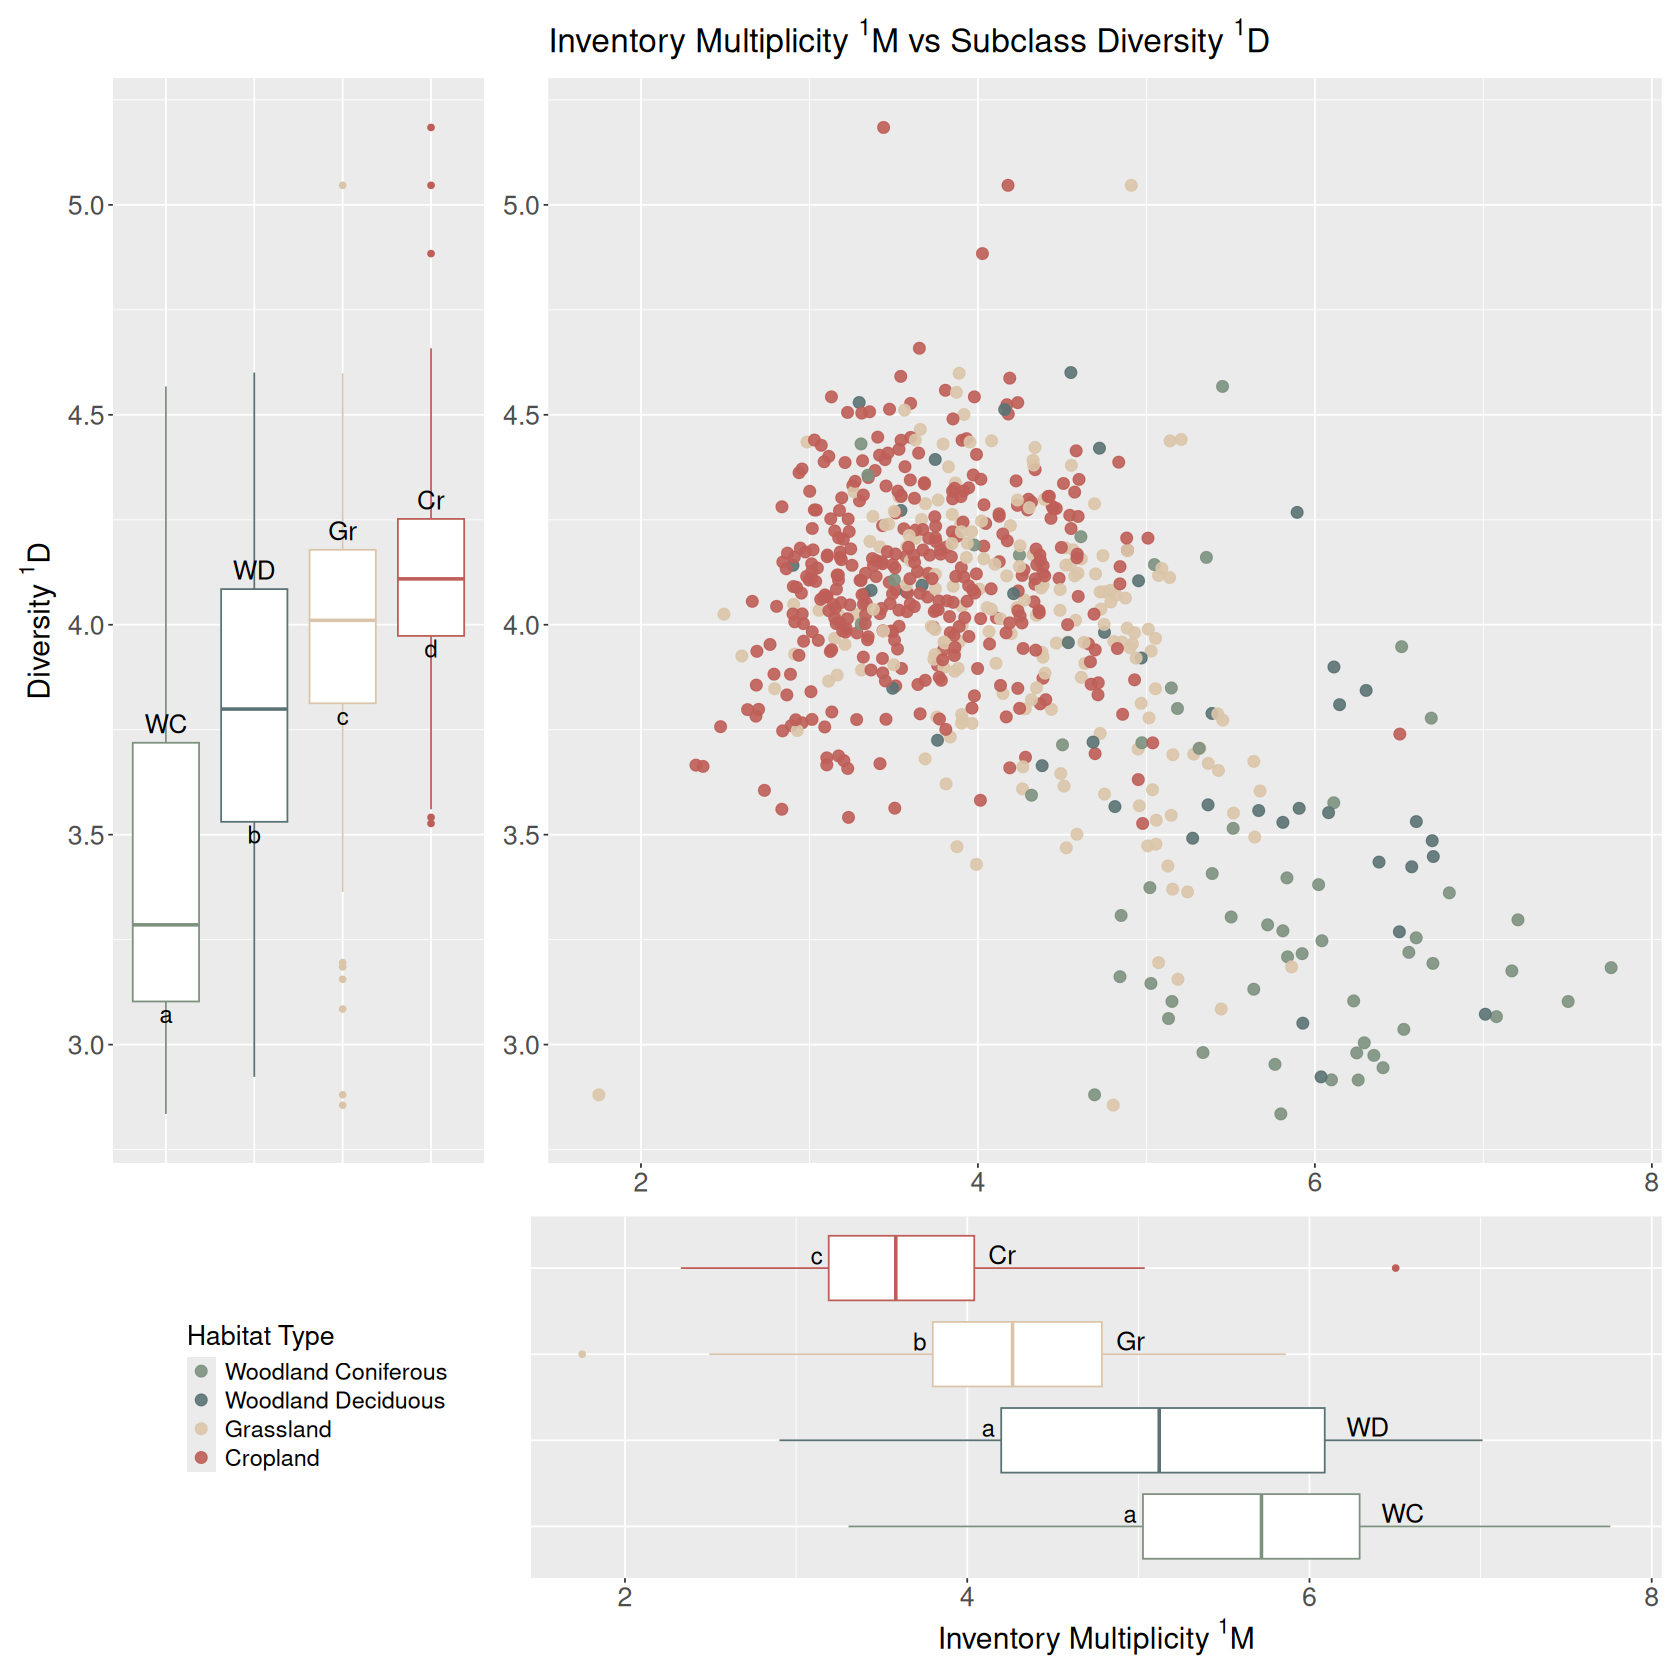

In [10]:

# Set plot size
options(repr.plot.width = 14, repr.plot.height = 14)


# Parameterrs
df <- data.frame(SampleID = df_filtered_ab$SampleID, div = div, mul = mul)
df <- df %>% inner_join(df_meta, by = "SampleID")




label_map <- c(
  "woodland_coniferous" = "Woodland Coniferous",
  "woodland_deciduous" = "Woodland Deciduous",
  "grassland" = "Grassland",
  "cropland" = "Cropland"
)

short_label_map <- c(
  "woodland_coniferous" = "WC",
  "woodland_deciduous" = "WD",
  "grassland" = "Gr",
  "cropland" = "Cr"
)

custom_colors <- c( 
                    '#7D917E',                 
                    '#5A7273',
                    '#DAC5AA',
                    '#BE5E58'
                    )


title <- TeX(paste0("Inventory Multiplicity $^1M$ vs ",l2, " Diversity $^1D$"))


plot_location <- "LUCAS/plots/srs_merged_plot.png"

cld_div <- compute_cld(dunn_result = tests_resp$dunn_div, short_label_order = short_label_order, label_order = label_order)
cld_mul <- compute_cld(dunn_result = tests_resp$dunn_mul, short_label_order = short_label_order, label_order = label_order)


final_plot <- plot_scatter_and_box_plot(  
  df= df,
  multiplicity_col= multiplicity_col,
  diversity_col= diversity_col,
  group_col= group_col,
  label_map= label_map,  
  short_label_map = short_label_map,
  custom_colors= custom_colors,
  title= title,
  multiplicity_name= TeX(multiplicity_name),
  diversity_name= TeX(diversity_name),
  group_name= group_name,
  plot_location= plot_location,
  cld_div= cld_div,
  cld_mul= cld_mul
)

final_plot

## Exploration by ARG (Class and Subclass)


In [ ]:
# Iterates over each row

target_level  <- "Subclass"


results  <- c()
for(sample in df_normalized$SampleID)
{

    print(sample)
    flush.console()

    df_ab_sample <- df_normalized[df_normalized$SampleID == sample,]
    genes <- colnames(df_ab_sample)
    df_ab_sample <- data.frame(t(df_ab_sample))
    df_ab_sample["Gene"] <-genes
    colnames(df_ab_sample) <- c("abundance", "Gene")
    df_ab_sample <- df_ab_sample[-1,]

    df_ab_sample <- inner_join(df_ab_sample, df_clust[,c("Gene", target_level)], by ="Gene")
    df_ab_sample$abundance  <-  as.integer(df_ab_sample$abundance)
    df_ab_sample <- df_ab_sample[df_ab_sample$abundance > 0,]

    # Gets the LandCover 
    lc  <- df_meta %>% filter(SampleID == sample) %>% pull(LandCover) 



    for(group in unique(df_ab_sample[[target_level]]))
    {

        df_temp  <- df_ab_sample %>% filter(.data[[target_level]] == group)
        ab  <-  df_temp$abundance
        clust <- df_temp  %>% pull(!!target_level)
        mul  <-  multiplicity.inventory(ab, clust)
        results  <-  rbind(results, c(group, lc, sample, mul, sum(ab)))
        


    }

    
}


df  <- as_tibble(results)
colnames(df) <- c("Group", "LandCover", "SampleID", "Multiplicity", "Abundance") 
df <- df %>% mutate(Multiplicity = as.numeric(Multiplicity), Abundance = as.numeric(Abundance))



[1] "L0001"
[1] "L0002"
[1] "L0003"
[1] "L0004"
[1] "L0005"
[1] "L0006"
[1] "L0007"
[1] "L0008"
[1] "L0009"
[1] "L0010"
[1] "L0011"
[1] "L0012"
[1] "L0013"
[1] "L0014"
[1] "L0015"
[1] "L0016"
[1] "L0017"
[1] "L0018"
[1] "L0019"
[1] "L0020"
[1] "L0021"
[1] "L0022"
[1] "L0023"
[1] "L0024"
[1] "L0025"
[1] "L0026"
[1] "L0027"
[1] "L0028"
[1] "L0029"
[1] "L0030"
[1] "L0031"
[1] "L0032"
[1] "L0033"
[1] "L0034"
[1] "L0035"
[1] "L0036"
[1] "L0037"
[1] "L0038"
[1] "L0039"
[1] "L0040"
[1] "L0041"
[1] "L0042"
[1] "L0043"
[1] "L0044"
[1] "L0045"
[1] "L0046"
[1] "L0047"
[1] "L0048"
[1] "L0049"
[1] "L0051"
[1] "L0052"
[1] "L0053"
[1] "L0054"
[1] "L0055"
[1] "L0056"
[1] "L0057"
[1] "L0058"
[1] "L0059"
[1] "L0060"
[1] "L0061"
[1] "L0062"
[1] "L0063"
[1] "L0064"
[1] "L0065"
[1] "L0067"
[1] "L0068"
[1] "L0069"
[1] "L0070"
[1] "L0071"
[1] "L0073"
[1] "L0075"
[1] "L0076"
[1] "L0077"
[1] "L0078"
[1] "L0079"
[1] "L0080"
[1] "L0081"
[1] "L0082"
[1] "L0083"
[1] "L0084"
[1] "L0086"
[1] "L0087"
[1] "L0090"
[1] 

`summarise()` has grouped output by 'SampleID'. You can override using the
`.groups` argument.


Group,totalAbundance,percentage
<chr>,<dbl>,<dbl>
rifamycin,915642,44.405787
multidrug,727582,35.285462
vancomycin,217506,10.548364
tetracycline,40736,1.975569
fosmidomycin,37510,1.819118
bacitracin,25327,1.228281
macrolide,25194,1.221831


`summarise()` has grouped output by 'SampleID'. You can override using the
`.groups` argument.


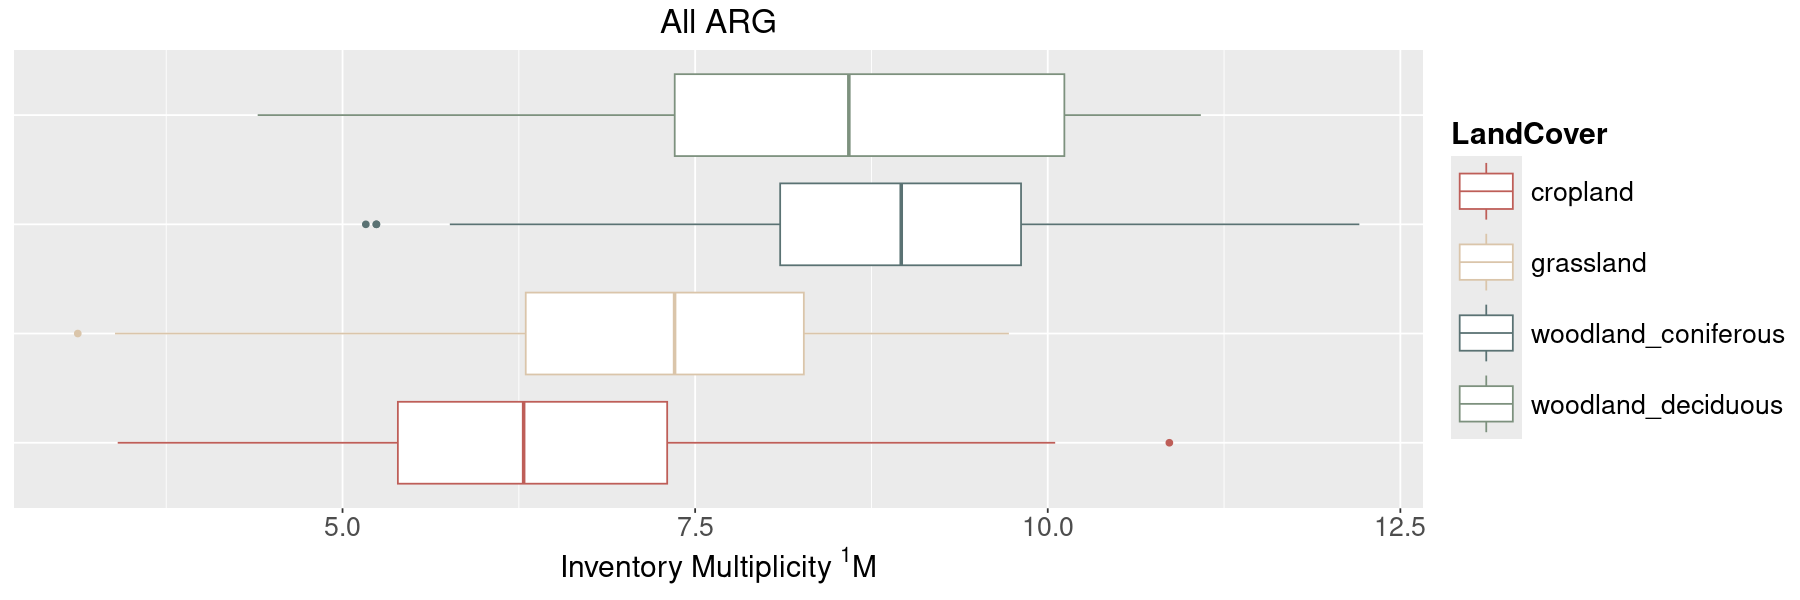

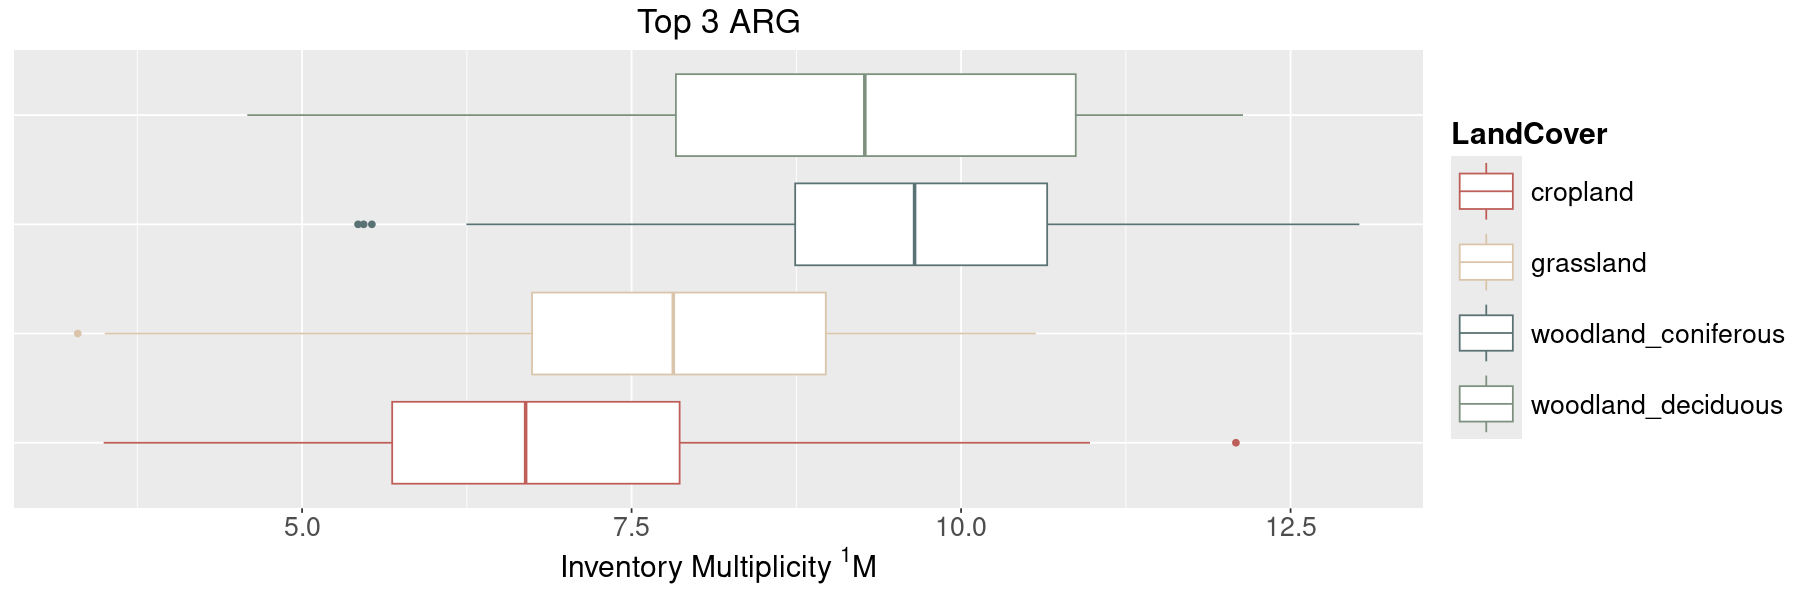

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 5)

min_abundance <- 200000




# Define custom colors
custom_colors <- c("#BE5E58", "#DAC5AA", "#5A7273", "#7D917E")
custom_colors <- setNames(custom_colors, c("cropland", "grassland", "woodland_coniferous", "woodland_deciduous"))


df_explore <- df %>% group_by(SampleID,LandCover) %>% 
summarise(TotalMultiplicity = weighted.mean(Multiplicity,Abundance)) %>% 
ungroup()


ggplot(df_explore, aes(x = LandCover, y = TotalMultiplicity, color = LandCover)) +
  geom_boxplot() +
  labs(
    # title = TeX("Inventory Multiplicity"),
    title = "All ARG",
    x = "Land Cover",
    y = TeX("Inventory Multiplicity $^1M$")
  )   +
  scale_x_discrete(labels = label_map) +
  scale_color_manual(values = custom_colors) +  # Add labels
      theme(
    axis.title = element_text(size = 18),   # Increase axis title font size
    axis.text = element_text(size = 16),    # Increase axis label font size
    plot.title = element_text(size = 20, hjust = 0.5),
    axis.text.y = element_blank(), # Remove x-axis text
    axis.ticks.y = element_blank(), 
    axis.title.y = element_blank() ,
      legend.text = element_text(size = 16),  # Increase legend text size
  legend.title = element_text(size = 18, face = "bold"),  # Increase legend title size
  legend.key.size = unit(1.5, "cm")  # Increase legend key size
  ) +
  coord_flip()   # Hides the legend

df_totals  <- df %>% 
              group_by(Group) %>% 
              summarise(totalAbundance = sum(Abundance)) %>%               
              arrange(-totalAbundance) %>% ungroup()

tot  <- sum(df_totals$totalAbundance)
df_totals <- df_totals %>% mutate(percentage = 100*totalAbundance/tot)              

selected_groups <- df_totals %>% filter(totalAbundance >= min_abundance) %>% pull(Group)




df_temp  <- df_totals %>% select(Group,totalAbundance,percentage)

head(df_temp, 7)

df_temp  <- df_temp %>% filter(totalAbundance >= min_abundance) %>% select(Group,totalAbundance,percentage)




df_explore <- df_temp %>% inner_join(df, by = "Group") %>% group_by(SampleID,LandCover) %>% 
summarise(TotalMultiplicity = weighted.mean(Multiplicity,Abundance)) %>% 
ungroup()


ggplot(df_explore, aes(x = LandCover, y = TotalMultiplicity, color = LandCover)) +
  geom_boxplot() +
  labs(
    # title = TeX("Inventory Multiplicity"),
    title = paste("Top",nrow(df_temp),"ARG"),
    x = "Land Cover",
    y = TeX("Inventory Multiplicity $^1M$")
  )   +
  scale_x_discrete(labels = label_map) +
  scale_color_manual(values = custom_colors) +  # Add labels
      theme(
    axis.title = element_text(size = 18),   # Increase axis title font size
    axis.text = element_text(size = 16),    # Increase axis label font size
    plot.title = element_text(size = 20, hjust = 0.5),
    axis.text.y = element_blank(), # Remove x-axis text
    axis.ticks.y = element_blank(), 
    axis.title.y = element_blank(),
      legend.text = element_text(size = 16),  # Increase legend text size
  legend.title = element_text(size = 18, face = "bold"),  # Increase legend title size
  legend.key.size = unit(1.5, "cm")  # Increase legend key size
  ) +
  coord_flip()   # Hides the legend


In [ ]:

target_level  <- "Subclass"


results  <- c()
for(sample in df_normalized$SampleID)
{

    print(sample)
    flush.console()

    df_ab_sample <- df_normalized[df_normalized$SampleID == sample,]
    genes <- colnames(df_ab_sample)
    df_ab_sample <- data.frame(t(df_ab_sample))
    df_ab_sample["Gene"] <-genes
    colnames(df_ab_sample) <- c("abundance", "Gene")
    df_ab_sample <- df_ab_sample[-1,]

    df_ab_sample <- inner_join(df_ab_sample, df_clust[,c("Gene", target_level)], by ="Gene")
    df_ab_sample$abundance  <-  as.integer(df_ab_sample$abundance)
    df_ab_sample <- df_ab_sample[df_ab_sample$abundance > 0,]

    # Gets the LandCover 
    lc  <- df_meta %>% filter(SampleID == sample) %>% pull(LandCover) 

    for(i in 1:length(selected_groups))
    {
        for(j in i:length(selected_groups))
        {
            group_1 <- selected_groups[i]
            group_2 <- selected_groups[j]

            group_label <- paste(group_1,"-",group_2)
            if(group_1 == group_2)
                group_label  <- group_1
            
            df_temp  <- df_ab_sample %>% filter(.data[[target_level]] == group_1 | .data[[target_level]] == group_2)
                                
            ab  <-  df_temp$abundance
            clust <- df_temp  %>% pull(!!target_level)
            mul  <-  multiplicity.inventory(ab, clust)
            results  <-  rbind(results, c(group_label, lc, sample, mul, sum(ab)))


        }
        
    }
    
}


df_pairs  <- as_tibble(results)
colnames(df_pairs) <- c("Group", "LandCover", "SampleID", "Multiplicity", "Abundance") 
df_pairs <- df_pairs %>% mutate(Multiplicity = as.numeric(Multiplicity), Abundance = as.numeric(Abundance))



[1] "L0001"
[1] "L0002"
[1] "L0003"
[1] "L0004"
[1] "L0005"
[1] "L0006"
[1] "L0007"
[1] "L0008"
[1] "L0009"
[1] "L0010"
[1] "L0011"
[1] "L0012"
[1] "L0013"
[1] "L0014"
[1] "L0015"
[1] "L0016"
[1] "L0017"
[1] "L0018"
[1] "L0019"
[1] "L0020"
[1] "L0021"
[1] "L0022"
[1] "L0023"
[1] "L0024"
[1] "L0025"
[1] "L0026"
[1] "L0027"
[1] "L0028"
[1] "L0029"
[1] "L0030"
[1] "L0031"
[1] "L0032"
[1] "L0033"
[1] "L0034"
[1] "L0035"
[1] "L0036"
[1] "L0037"
[1] "L0038"
[1] "L0039"
[1] "L0040"
[1] "L0041"
[1] "L0042"
[1] "L0043"
[1] "L0044"
[1] "L0045"
[1] "L0046"
[1] "L0047"
[1] "L0048"
[1] "L0049"
[1] "L0051"
[1] "L0052"
[1] "L0053"
[1] "L0054"
[1] "L0055"
[1] "L0056"
[1] "L0057"
[1] "L0058"
[1] "L0059"
[1] "L0060"
[1] "L0061"
[1] "L0062"
[1] "L0063"
[1] "L0064"
[1] "L0065"
[1] "L0067"
[1] "L0068"
[1] "L0069"
[1] "L0070"
[1] "L0071"
[1] "L0073"
[1] "L0075"
[1] "L0076"
[1] "L0077"
[1] "L0078"
[1] "L0079"
[1] "L0080"
[1] "L0081"
[1] "L0082"
[1] "L0083"
[1] "L0084"
[1] "L0086"
[1] "L0087"
[1] "L0090"
[1] 

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


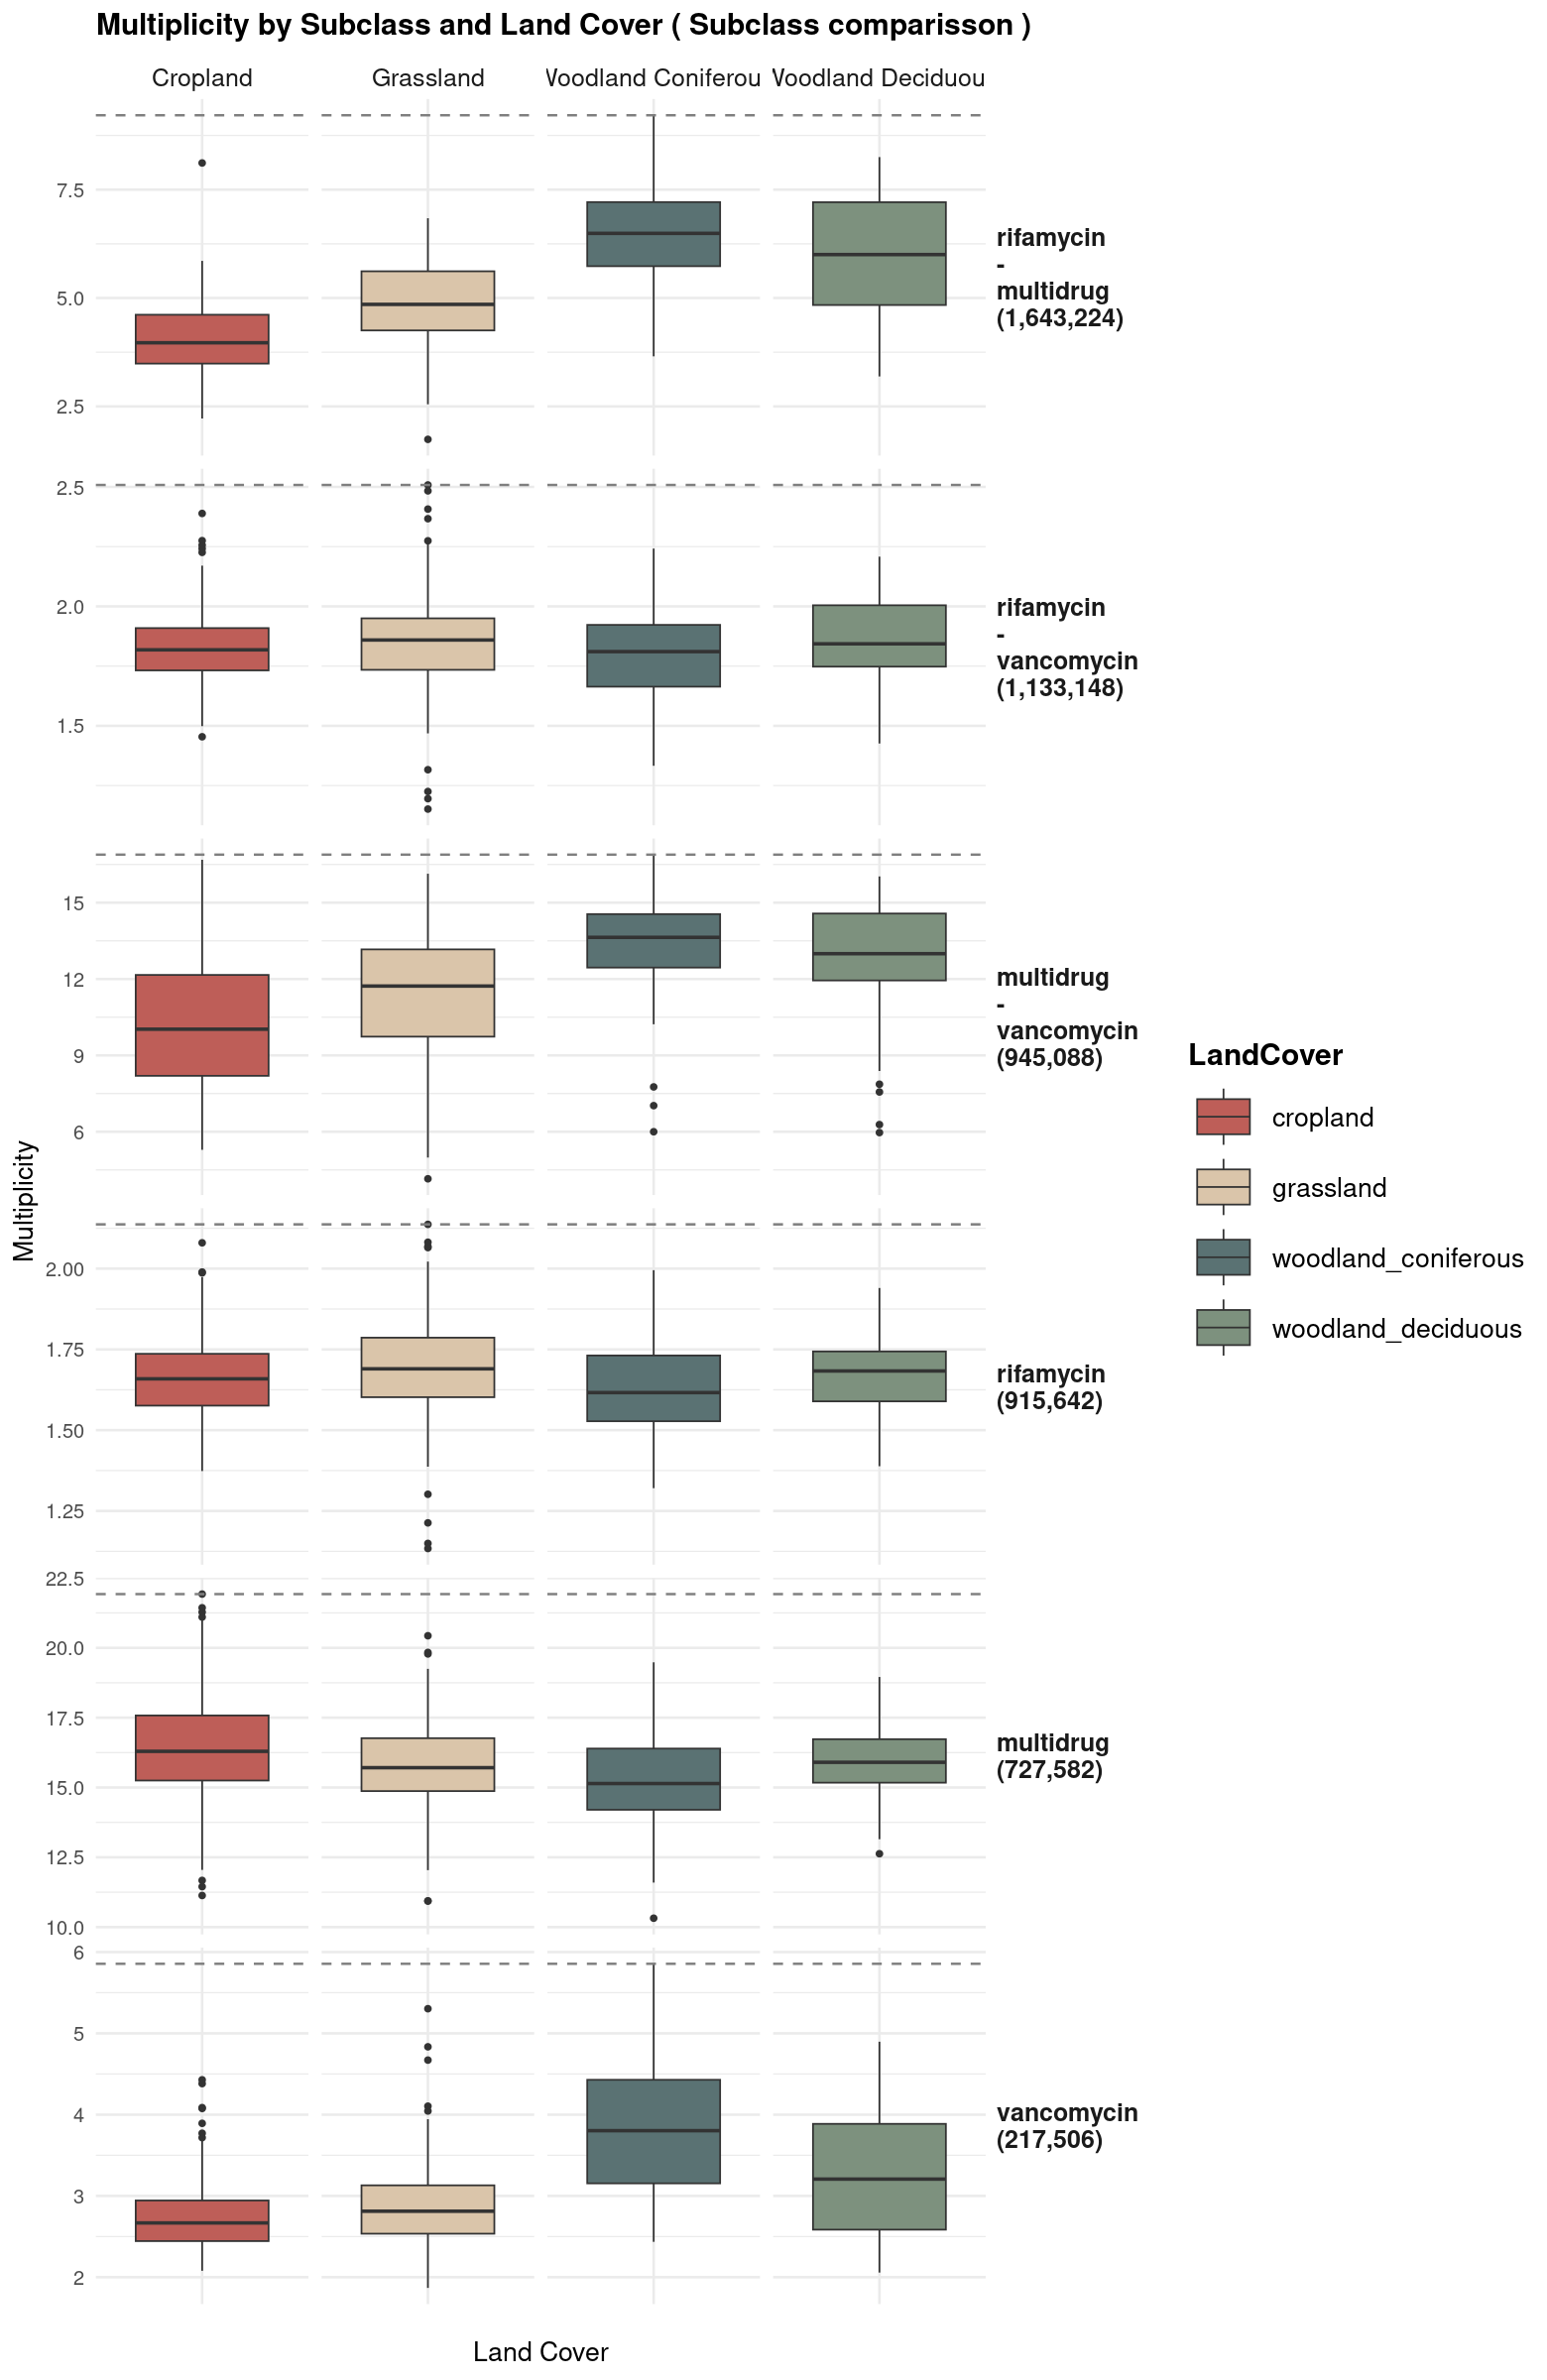

In [ ]:
options(repr.plot.width = 13, repr.plot.height = 20)


df_plot <- df_pairs 

df_temp  <- df_pairs %>% select(Group, Abundance) %>% group_by(Group) %>% summarise(totalAbundance = sum(Abundance))  %>% arrange(-totalAbundance)

# Create a lookup table for Group labels with TotalAbundance
df_group_labels <- df_temp %>%
  distinct(Group, totalAbundance) %>%
  mutate(GroupLabel = Group, totalAbundance = formatC(totalAbundance, format = "f", big.mark = ",", digits = 0)) %>% 
  mutate(GroupLabel = str_replace_all(GroupLabel, "_", " "))  %>% 
  mutate(GroupLabel = str_replace_all(GroupLabel, ";", " "))  %>% 
  mutate(GroupLabel = str_replace_all(GroupLabel, ",", " "))  %>% 
  mutate(GroupLabel = str_wrap(GroupLabel, width = 10))  %>% 
  mutate(GroupLabel = paste0(GroupLabel, "\n(", totalAbundance, ")")) 



# Sorts
df_plot <- df_plot %>%
  mutate(Group = factor(Group, levels = df_temp$Group))


# Custom label mapping function
group_labeller <- function(variable, value) {
  setNames(df_group_labels$GroupLabel, df_group_labels$Group)[value]
}


# Define label mapping
label_map <- c(
  "woodland_deciduous" = "Woodland Deciduous",
  "woodland_coniferous" = "Woodland Coniferous",
  "grassland" = "Grassland",
  "cropland" = "Cropland"
)

# Define custom colors
custom_colors <- c("#BE5E58", "#DAC5AA", "#5A7273", "#7D917E")
custom_colors <- setNames(custom_colors, c("cropland", "grassland", "woodland_coniferous", "woodland_deciduous"))


# Calculate horizontal line positions dynamically
hline_positions <- df_plot %>%
  group_by(Group) %>%
  summarise(y_max = max(Multiplicity), .groups = "drop") %>%
  mutate(y_sep = lead(y_max))  # Get separation lines


ggplot(df_plot, aes(x = "", y = Multiplicity, fill = LandCover)) +  # Empty x-axis for boxplots
  geom_boxplot() +
     #geom_jitter(width = 0.1, alpha = 0.25, color = "#3A3A3A") +
  geom_hline(data = hline_positions, aes(yintercept = y_max), linetype = "dashed", color = "gray50", size = 0.7, na.rm = TRUE) +
  facet_grid(Group ~ LandCover, labeller = labeller(LandCover = label_map, Group = group_labeller), scales = "free_y") +  # Create a grid layout
    scale_fill_manual(values = custom_colors) +  # Apply custom colors

  labs(x = "Land Cover", y = "Multiplicity", title = paste("Multiplicity by",target_level ,"and Land Cover (", target_level,"comparisson )")) +
    theme_minimal(base_size = 16) +  # Increase text size
  theme(
    strip.text = element_text(size = 15),  # Larger facet labels
    axis.text = element_text(size = 12),   # Larger axis labels
    strip.text.y = element_text(size = 15, face = "bold", angle = 0, hjust = 0),  # Rotate labels horizontally
    plot.title = element_text(size = 18, face = "bold"),
    #legend.position = "none",
    legend.text = element_text(size = 16),  # Increase legend text size
  legend.title = element_text(size = 18, face = "bold"),  # Increase legend title size
  legend.key.size = unit(1.5, "cm") 
    )  # Bigger title

ggsave(paste0("LUCAS/plots/",target_level,"_",target_level,".jpg", sep=""), width = 18, height = 50, dpi = 400, limitsize = FALSE)


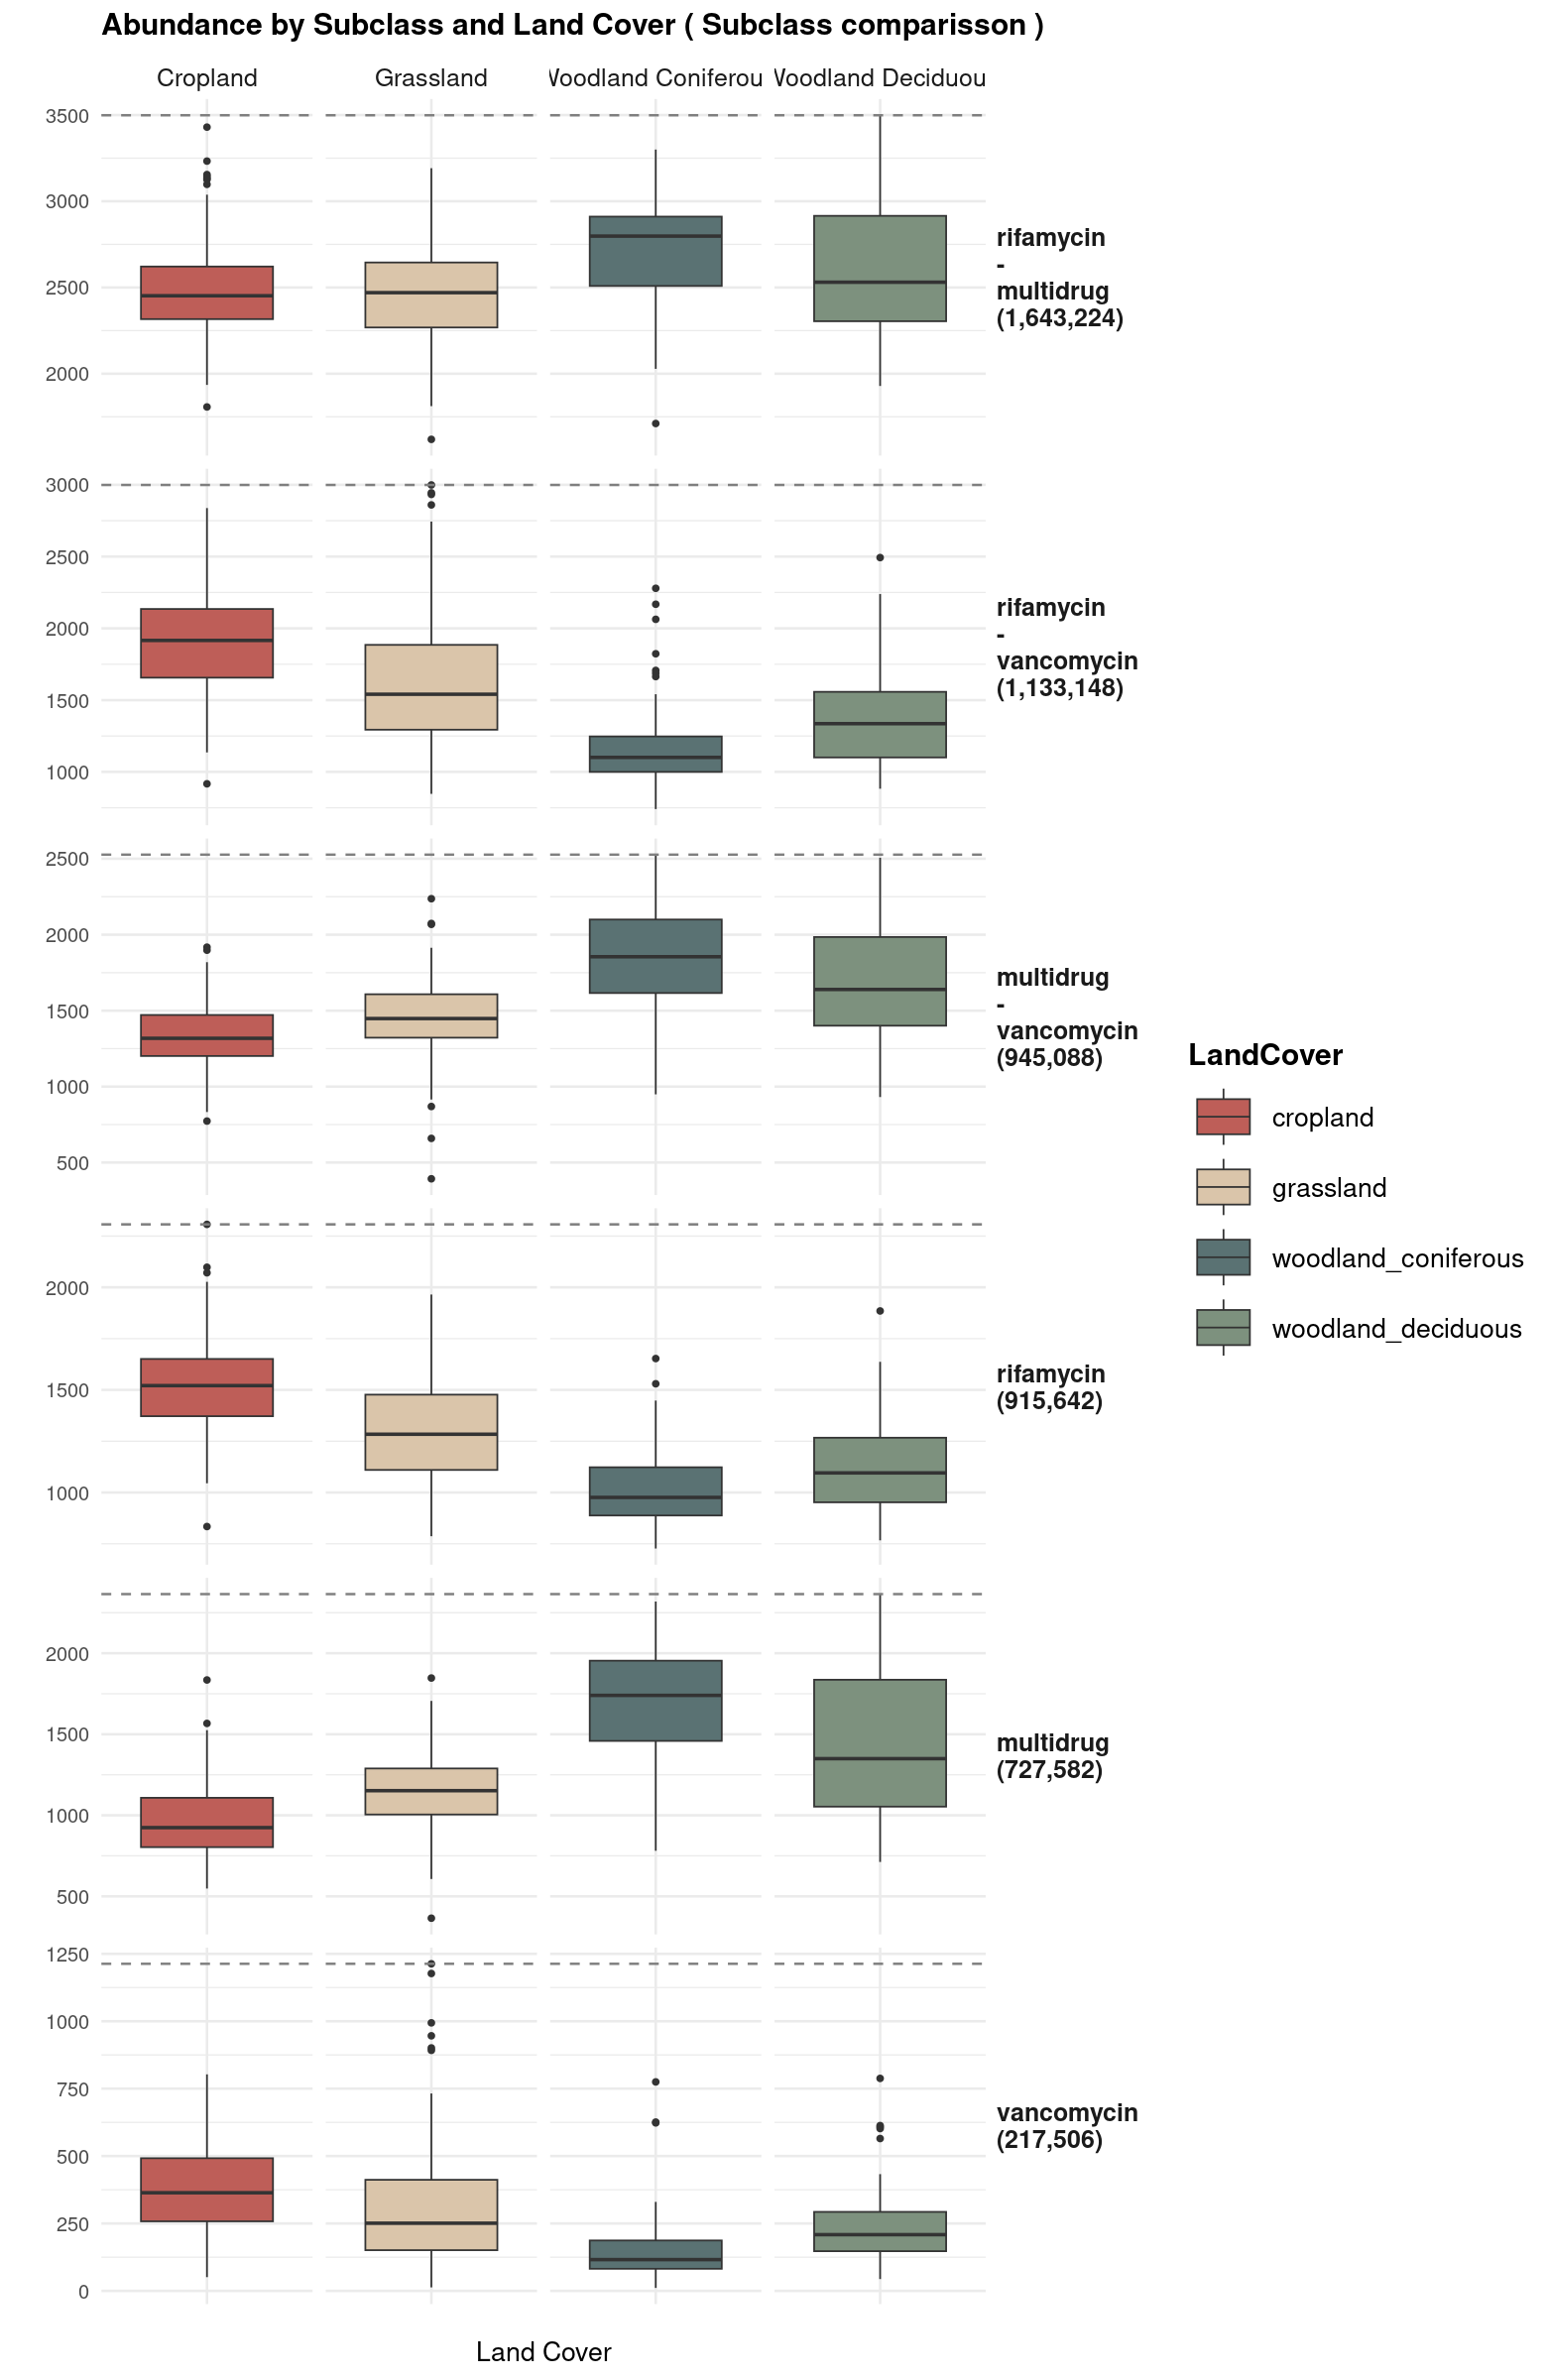

In [ ]:
options(repr.plot.width = 13, repr.plot.height = 20)


df_plot <- df_pairs 

df_temp  <- df_pairs %>% select(Group, Abundance) %>% group_by(Group) %>% summarise(totalAbundance = sum(Abundance))  %>% arrange(-totalAbundance)

# Create a lookup table for Group labels with TotalAbundance
df_group_labels <- df_temp %>%
  distinct(Group, totalAbundance) %>%
  mutate(GroupLabel = Group, totalAbundance = formatC(totalAbundance, format = "f", big.mark = ",", digits = 0)) %>% 
  mutate(GroupLabel = str_replace_all(GroupLabel, "_", " "))  %>% 
  mutate(GroupLabel = str_replace_all(GroupLabel, ";", " "))  %>% 
  mutate(GroupLabel = str_replace_all(GroupLabel, ",", " "))  %>% 
  mutate(GroupLabel = str_wrap(GroupLabel, width = 10))  %>% 
  mutate(GroupLabel = paste0(GroupLabel, "\n(", totalAbundance, ")")) 



# Sorts
df_plot <- df_plot %>%
  mutate(Group = factor(Group, levels = df_temp$Group))


# Custom label mapping function
group_labeller <- function(variable, value) {
  setNames(df_group_labels$GroupLabel, df_group_labels$Group)[value]
}


# Define label mapping
label_map <- c(
  "woodland_deciduous" = "Woodland Deciduous",
  "woodland_coniferous" = "Woodland Coniferous",
  "grassland" = "Grassland",
  "cropland" = "Cropland"
)

# Define custom colors
custom_colors <- c("#BE5E58", "#DAC5AA", "#5A7273", "#7D917E")
custom_colors <- setNames(custom_colors, c("cropland", "grassland", "woodland_coniferous", "woodland_deciduous"))


# Calculate horizontal line positions dynamically
hline_positions <- df_plot %>%
  group_by(Group) %>%
  summarise(y_max = max(Abundance), .groups = "drop") %>%
  mutate(y_sep = lead(y_max))  # Get separation lines


ggplot(df_plot, aes(x = "", y = Abundance, fill = LandCover)) +  # Empty x-axis for boxplots
  geom_boxplot() +
     #geom_jitter(width = 0.1, alpha = 0.25, color = "#3A3A3A") +
  geom_hline(data = hline_positions, aes(yintercept = y_max), linetype = "dashed", color = "gray50", size = 0.7, na.rm = TRUE) +
  facet_grid(Group ~ LandCover, labeller = labeller(LandCover = label_map, Group = group_labeller), scales = "free_y") +  # Create a grid layout
    scale_fill_manual(values = custom_colors) +  # Apply custom colors

  labs(x = "Land Cover", y = "", title = paste("Abundance by",target_level ,"and Land Cover (", target_level,"comparisson )")) +
    theme_minimal(base_size = 16) +  # Increase text size
  theme(
    strip.text = element_text(size = 15),  # Larger facet labels
    axis.text = element_text(size = 12),   # Larger axis labels
    strip.text.y = element_text(size = 15, face = "bold", angle = 0, hjust = 0),  # Rotate labels horizontally
    plot.title = element_text(size = 18, face = "bold"),
        #legend.position = "none",
          legend.text = element_text(size = 16),  # Increase legend text size
  legend.title = element_text(size = 18, face = "bold"),  # Increase legend title size
  legend.key.size = unit(1.5, "cm") )  # Bigger title

ggsave(paste0("LUCAS/plots/",target_level,"_",target_level,".jpg", sep=""), width = 18, height = 50, dpi = 400, limitsize = FALSE)


[1] "cropland : 0.13715970661191"
[1] "grassland : 0.140891187740673"
[1] "woodland_coniferous : 0.247771924354067"
[1] "woodland_deciduous : 0.072393589596172"


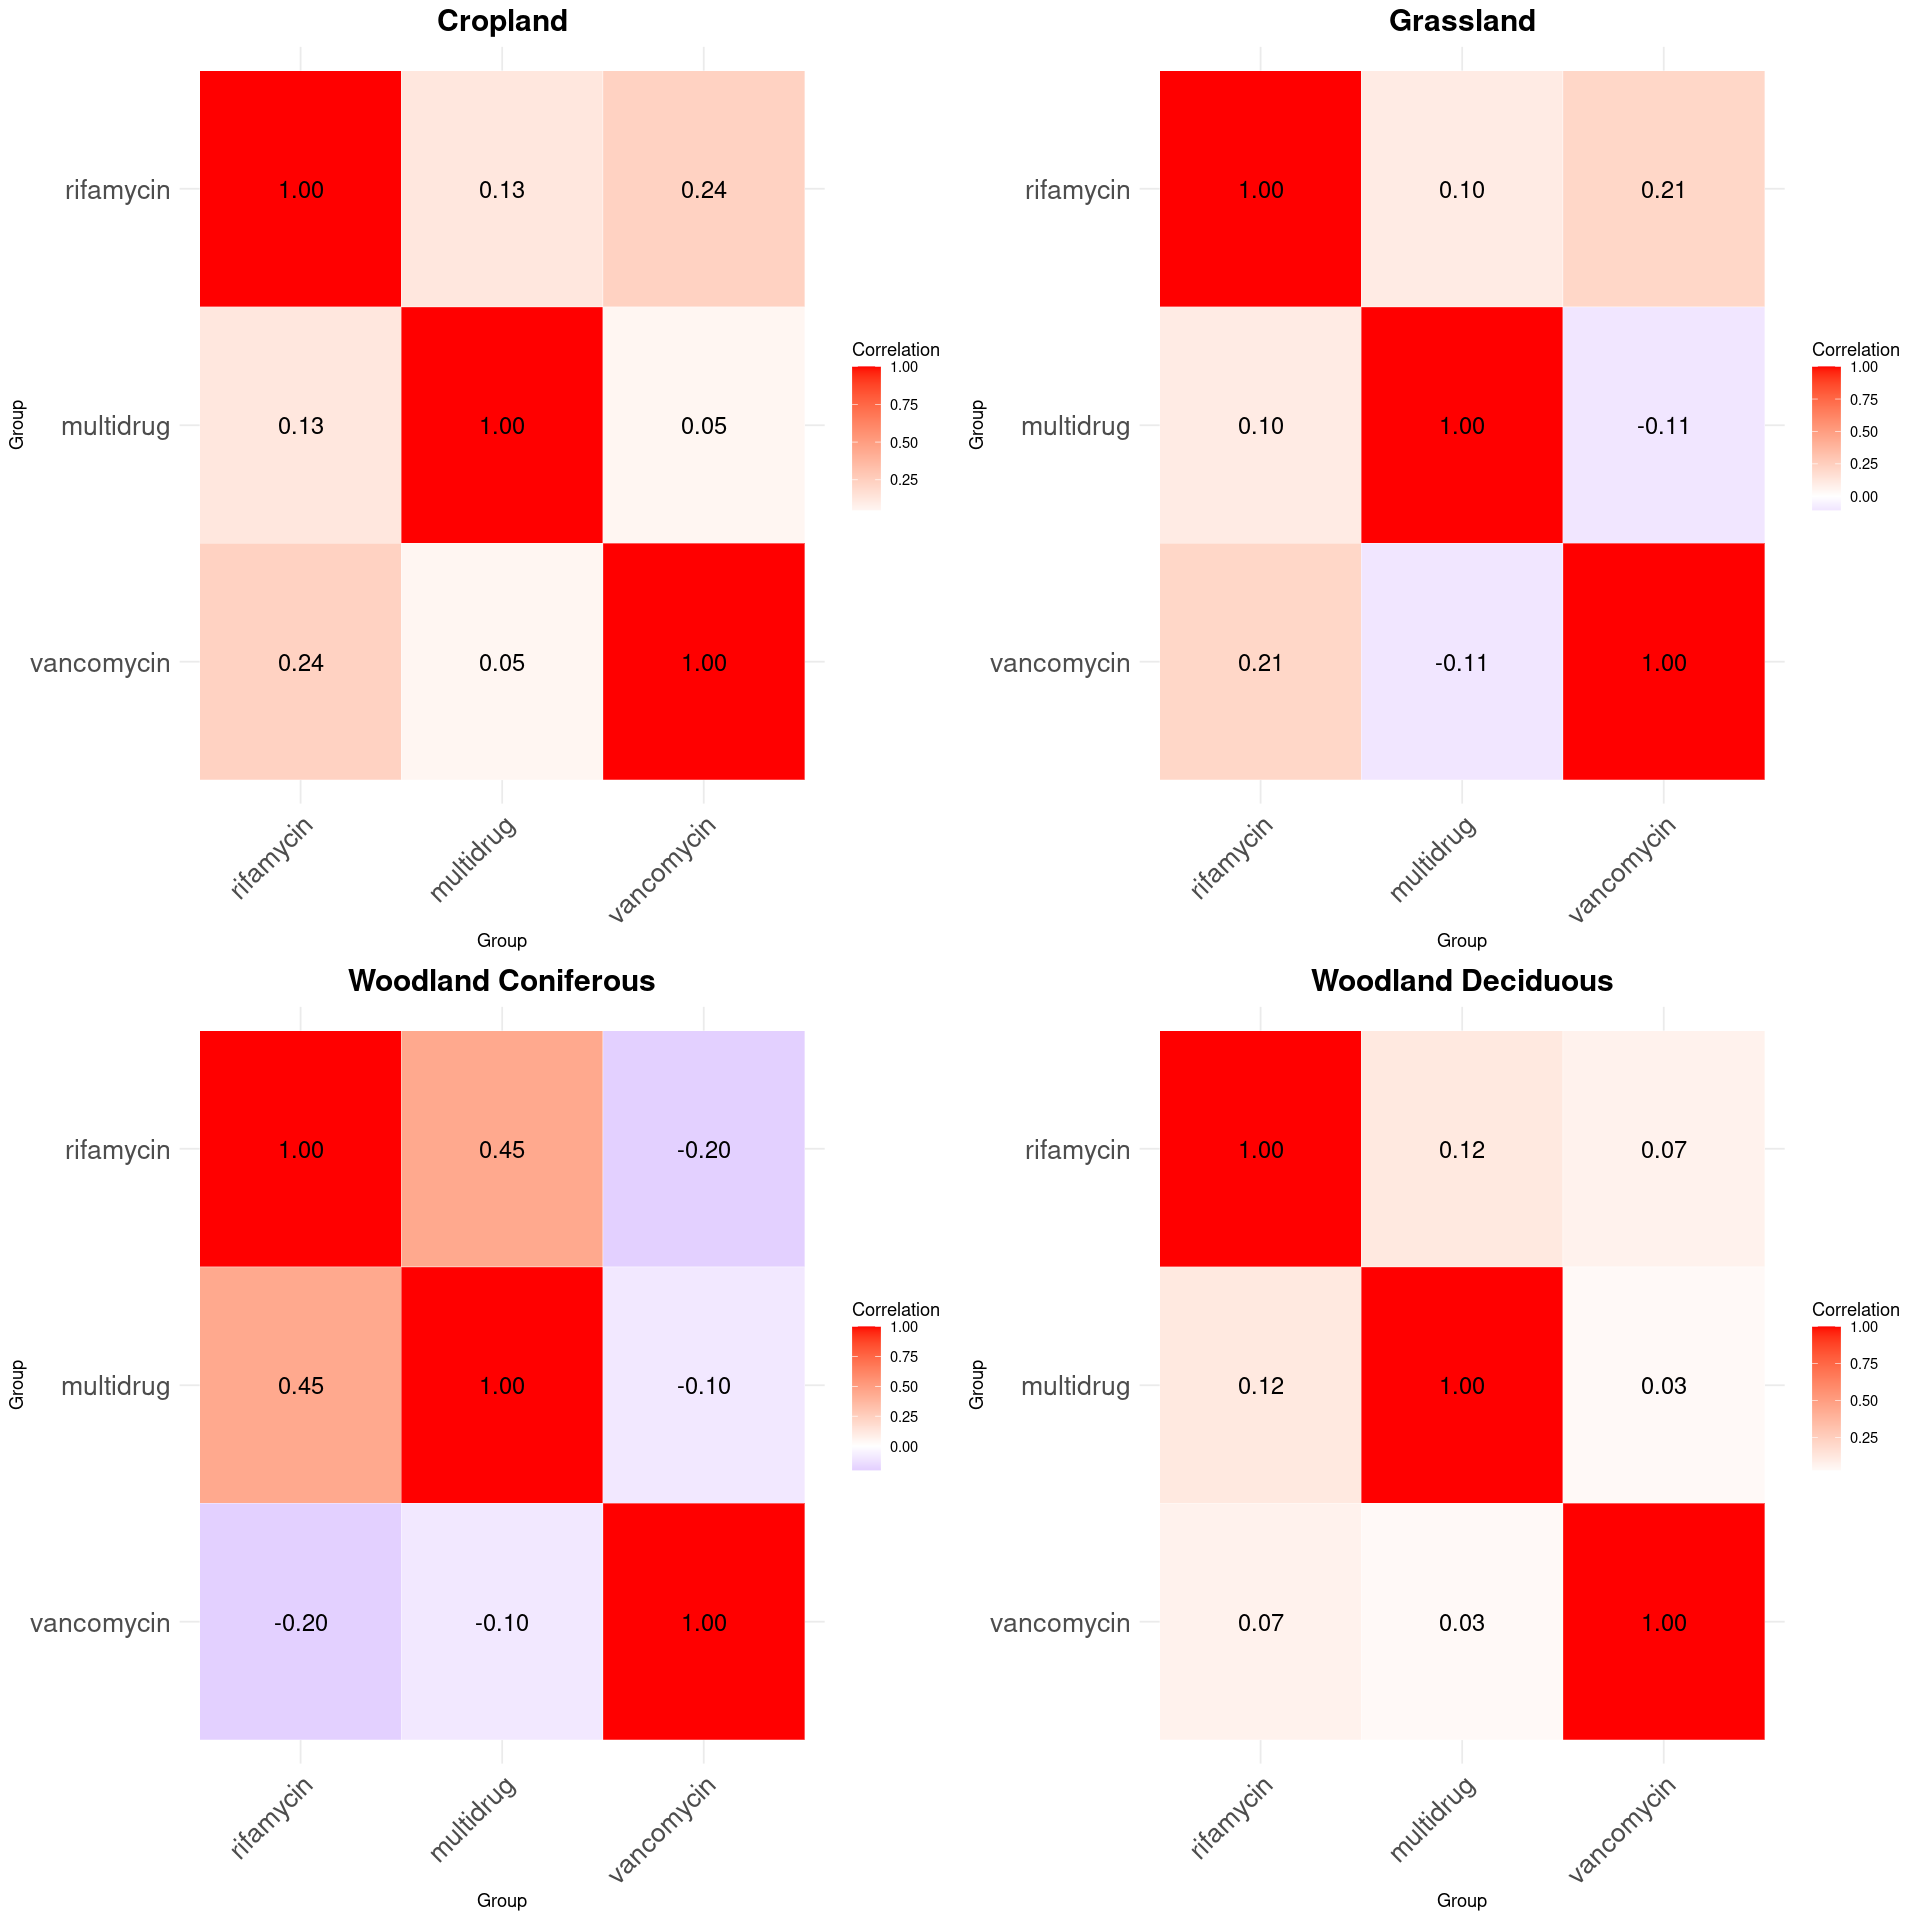

In [ ]:

df_temp  <- df_totals %>% filter(totalAbundance >= min_abundance) %>% select(Group,totalAbundance)

df_filtered <- df_temp %>% inner_join(df_plot, by = "Group")

options(repr.plot.width = 16, repr.plot.height = 16)
ps <- list()

for(lc in c("cropland", "grassland", "woodland_coniferous", "woodland_deciduous"))
{

  df_crosstab <- df_filtered %>%
  filter(LandCover == lc) %>% 
  select(SampleID, Group, Multiplicity) %>% 
    pivot_wider(names_from = Group, values_from = Multiplicity,values_fill = 0) %>%
    column_to_rownames("SampleID")


  cor_matrix <- cor(df_crosstab, use = "pairwise.complete.obs")  # Handle missing values


  # Convert correlation matrix into long format for ggplot
  cor_long <- as.data.frame(as.table(cor_matrix))

  # Plot the correlation heatmap
  p <-  ggplot(cor_long, aes(Var1, Var2, fill = Freq)) +
    geom_tile(color = "white") +  # White grid lines for clarity
      geom_text(aes(label = sprintf("%.2f", Freq)), color = "black", size = 5) +  # Add text label
    scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +  # Diverging colors
      scale_y_discrete(limits = rev(levels(cor_long$Var2))) +  # Reverse Y-axis order
    theme_minimal() +
    labs(title = label_map[lc],        
        x = "Group", y = "Group", fill = "Correlation") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
    axis.text = element_text(size = 16))

  ps[[length(ps)+1]] = p

  print(paste(lc,":", mean(abs(cor_matrix[upper.tri(cor_matrix)]))))

  

}


do.call(grid.arrange, c(ps, ncol = 2))


[1] "cropland : 0.451451606235798"
[1] "grassland : 0.531971925167579"
[1] "woodland_coniferous : 0.59058347488071"
[1] "woodland_deciduous : 0.641824677380283"


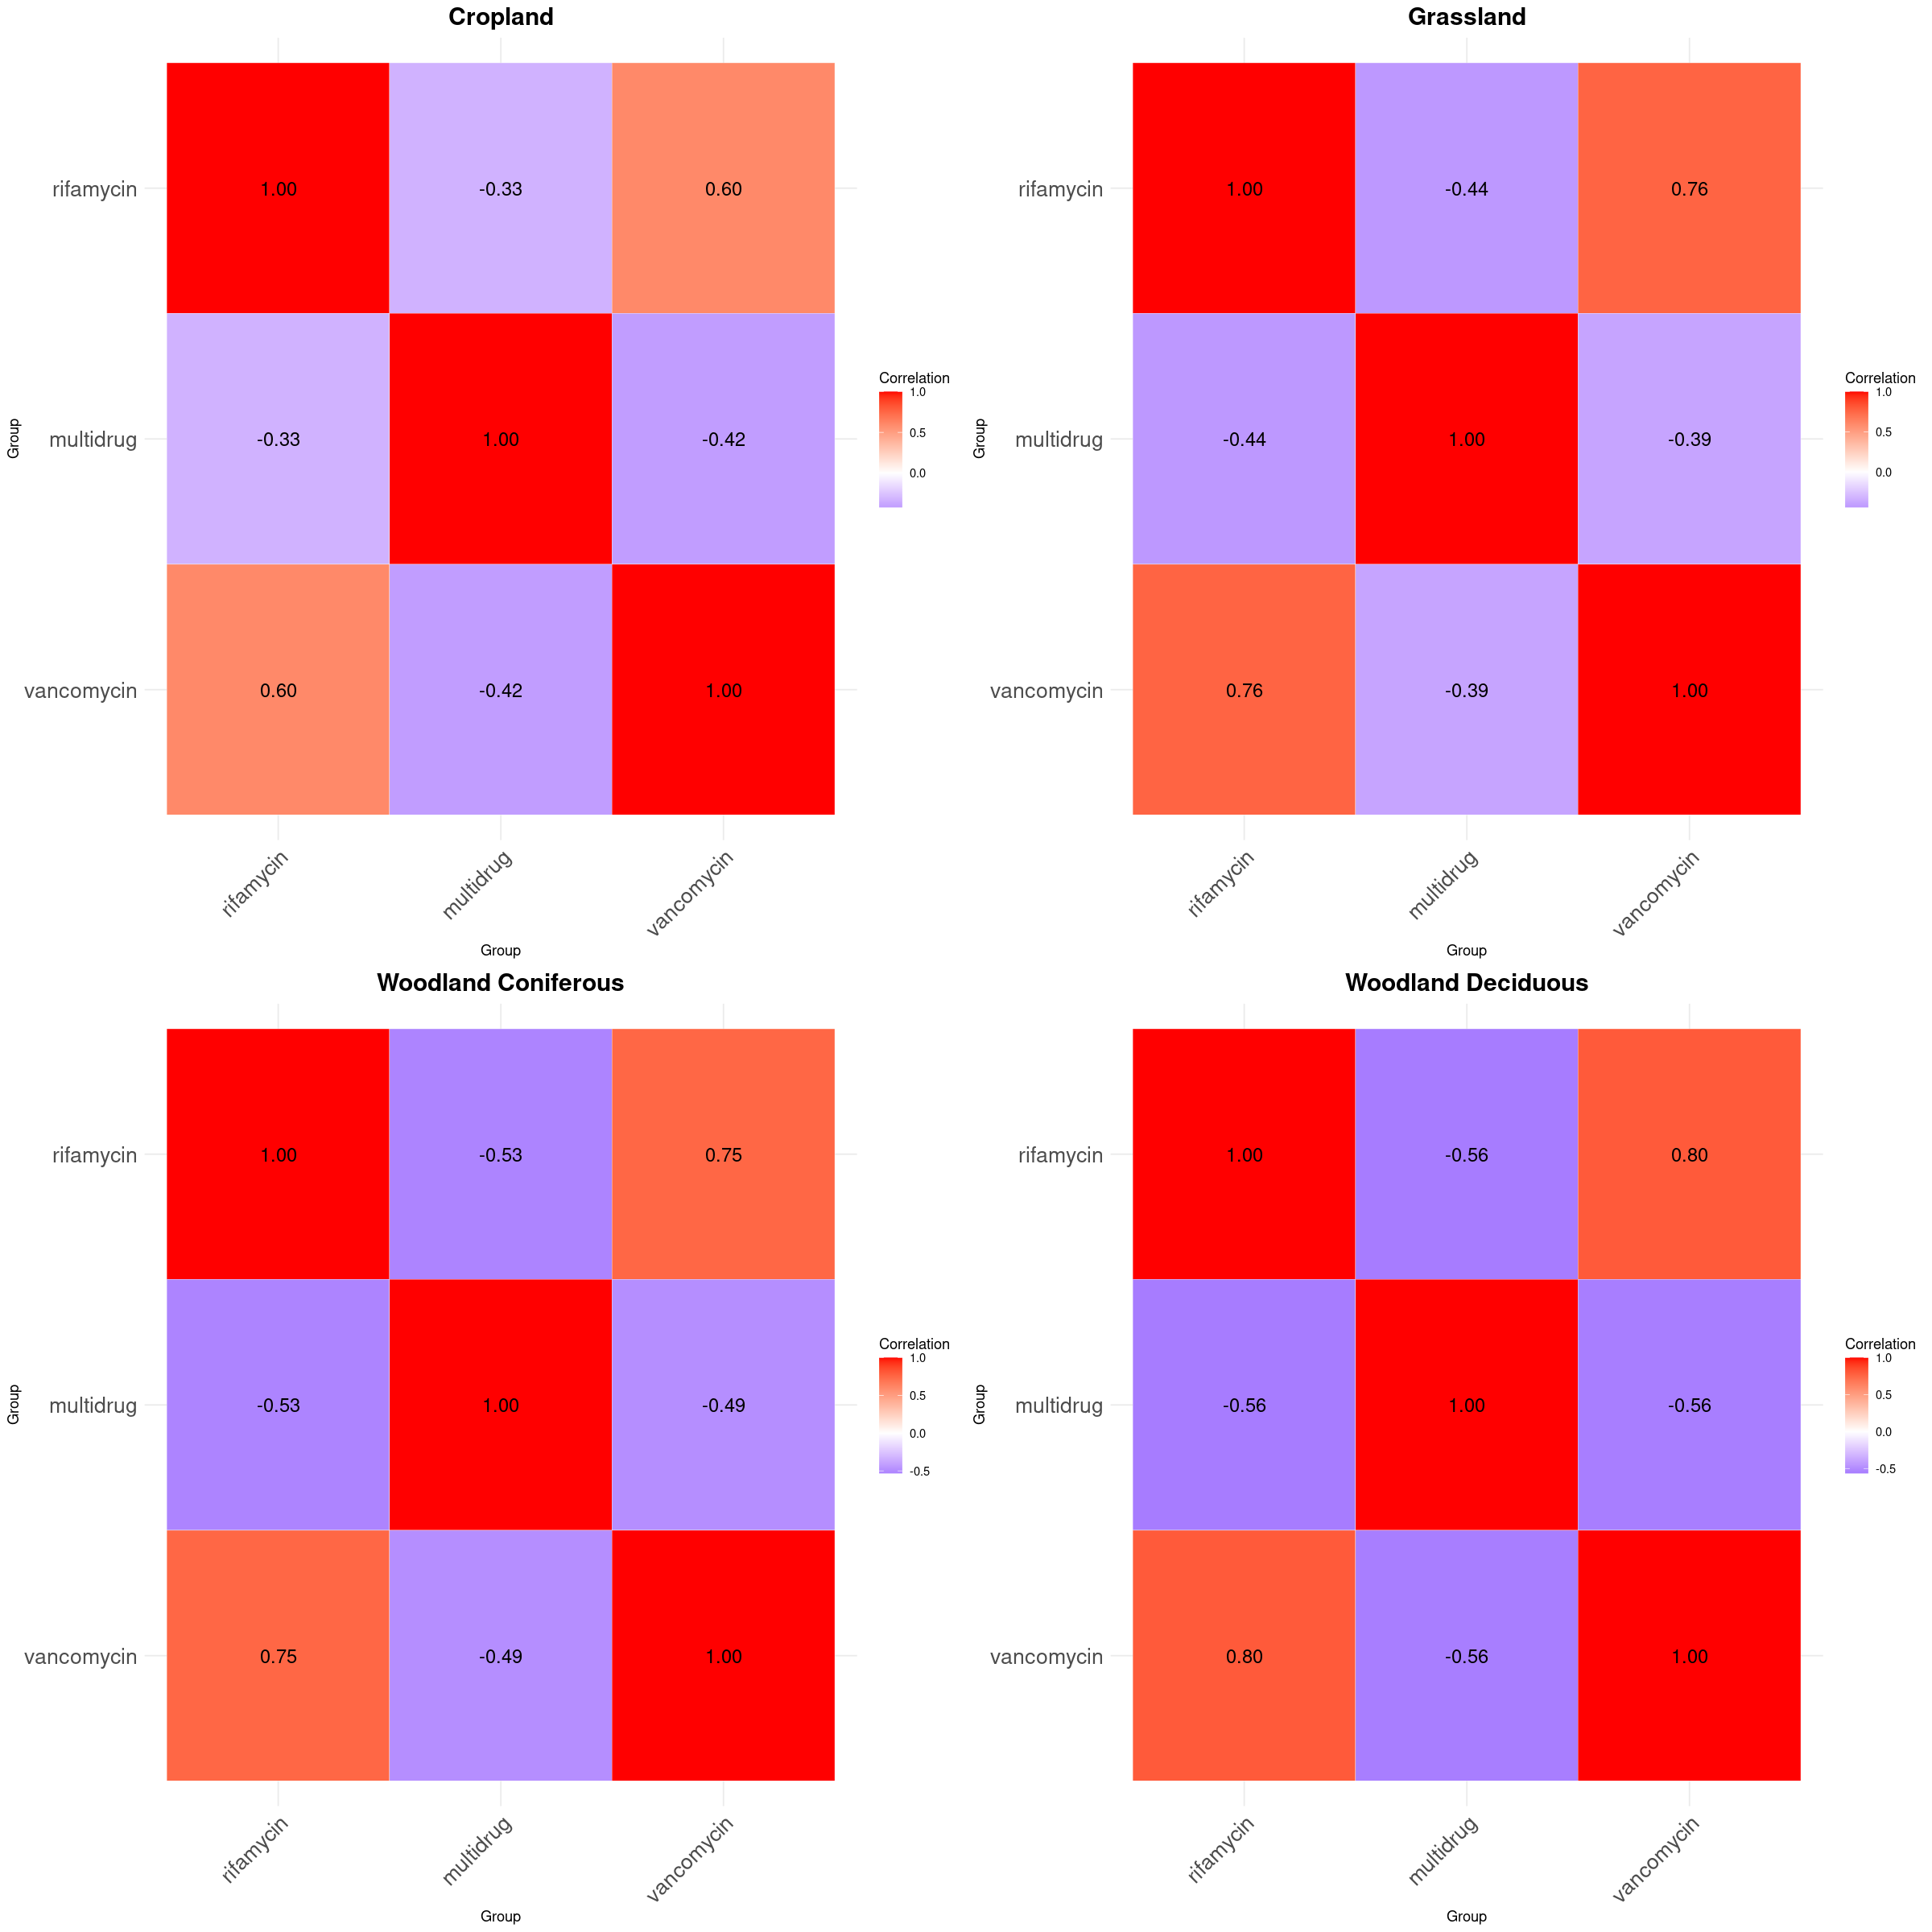

In [ ]:


df_temp  <- df_totals %>% filter(totalAbundance >= min_abundance) %>% select(Group,totalAbundance)

df_filtered <- df_temp %>% inner_join(df_plot, by = "Group")

options(repr.plot.width = 20, repr.plot.height = 20)
ps <- list()

for(lc in c("cropland", "grassland", "woodland_coniferous", "woodland_deciduous"))
{

  df_crosstab <- df_filtered %>%
  filter(LandCover == lc) %>% 
  select(SampleID, Group, Abundance) %>% 
    pivot_wider(names_from = Group, values_from = Abundance,values_fill = 0) %>%
    column_to_rownames("SampleID")


  cor_matrix <- cor(df_crosstab, use = "pairwise.complete.obs")  # Handle missing values


  # Convert correlation matrix into long format for ggplot
  cor_long <- as.data.frame(as.table(cor_matrix))

  # Plot the correlation heatmap
  p <-  ggplot(cor_long, aes(Var1, Var2, fill = Freq)) +
    geom_tile(color = "white") +  # White grid lines for clarity
      geom_text(aes(label = sprintf("%.2f", Freq)), color = "black", size = 5) +  # Add text label
    scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +  # Diverging colors
      scale_y_discrete(limits = rev(levels(cor_long$Var2))) +  # Reverse Y-axis order
    theme_minimal() +
    labs(title = label_map[lc],        
        x = "Group", y = "Group", fill = "Correlation") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
    axis.text = element_text(size = 16))

  ps[[length(ps)+1]] = p

  print(paste(lc,":", mean(abs(cor_matrix[upper.tri(cor_matrix)]))))

  

}


do.call(grid.arrange, c(ps, ncol = 2))

In [ ]:

df_temp  <- df_totals %>% filter(totalAbundance >= min_abundance) %>% select(Group,totalAbundance)

df_filtered <- df_temp %>% inner_join(df_plot, by = "Group")

options(repr.plot.width = 20, repr.plot.height = 20)
ps <- list()



for(lc in c("cropland", "grassland", "woodland_coniferous", "woodland_deciduous"))
{
    print(lc)
    for(g in selected_groups)
    {

      df_temp <- df_filtered %>%
          filter(LandCover == lc & Group == g)

      cor_res <-  cor(df_temp %>% pull(Multiplicity), df_temp %>% pull(Abundance), method = "pearson")
      print(paste0("   ",g, ": ", cor_res, sep=""))


    }


  

}




[1] "cropland"
[1] "   rifamycin: 0.124689505320116"
[1] "   multidrug: 0.551266723859413"
[1] "   vancomycin: 0.0386788354939286"
[1] "grassland"
[1] "   rifamycin: 0.314506023605931"
[1] "   multidrug: 0.133026625592415"
[1] "   vancomycin: 0.0768484873200469"
[1] "woodland_coniferous"
[1] "   rifamycin: 0.579856206910085"
[1] "   multidrug: -0.0334608674580346"
[1] "   vancomycin: -0.329206832145449"
[1] "woodland_deciduous"
[1] "   rifamycin: 0.579385176534462"
[1] "   multidrug: 0.171768115066172"
[1] "   vancomycin: -0.11448055371568"


`geom_smooth()` using formula = 'y ~ x'


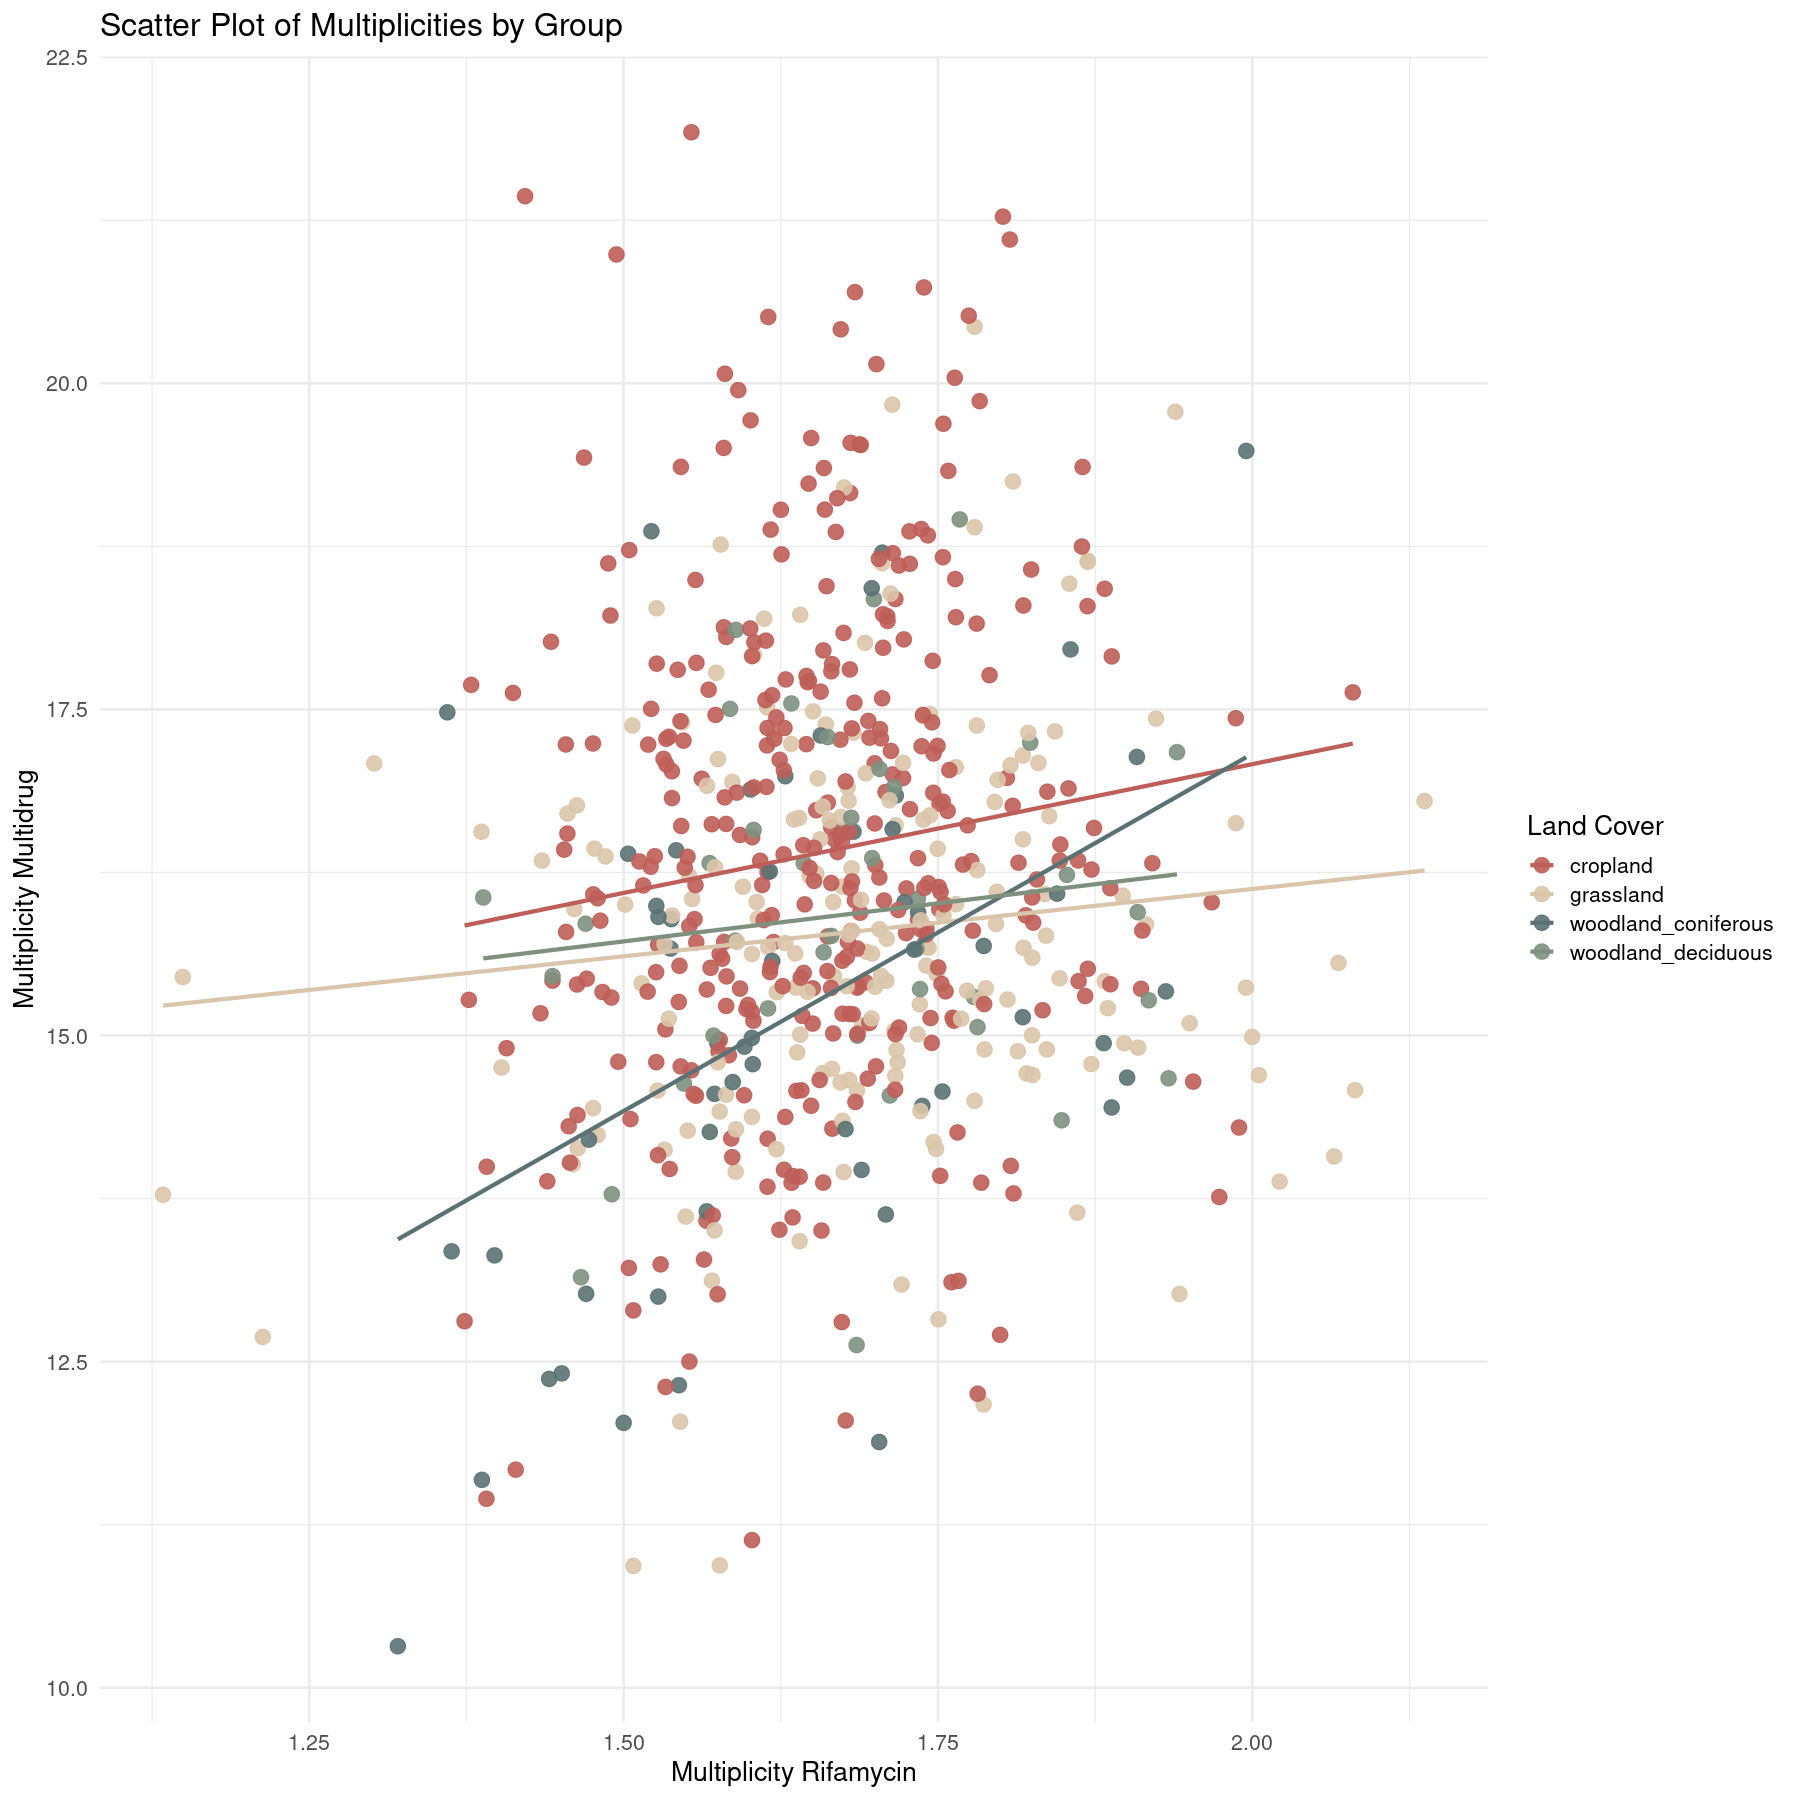

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 15)


df_plot_1 <- df_pairs %>% filter(Group %in% c("rifamycin"))  %>% mutate(MultiplicityRifamycin = Multiplicity) %>% select(LandCover, SampleID, MultiplicityRifamycin)
df_plot_2 <- df_pairs %>% filter(Group %in% c("multidrug"))%>% mutate(MultiplicityMultidrug = Multiplicity) %>% select(LandCover, SampleID, MultiplicityMultidrug)

df_plot <- df_plot_1 %>% inner_join(df_plot_2, by = c("LandCover","SampleID"))

#df_plot <- df_plot %>% filter(LandCover %in% c("cropland","woodland_coniferous"))


# Define label mapping
label_map <- c(
  "woodland_deciduous" = "Woodland Deciduous",
  "woodland_coniferous" = "Woodland Coniferous",
  "grassland" = "Grassland",
  "cropland" = "Cropland"
)

# Define custom colors
custom_colors <- c("#BE5E58", "#DAC5AA", "#5A7273", "#7D917E")
custom_colors <- setNames(custom_colors, c("cropland", "grassland", "woodland_coniferous", "woodland_deciduous"))

# Scatter plot
ggplot(df_plot, aes(x = MultiplicityRifamycin, y = MultiplicityMultidrug, color = LandCover)) +
  geom_point(size = 4, alpha = 0.9) +  # Customize point size and transparency
    geom_smooth(method = "lm", se = FALSE, linewidth = 1.2) +  # Add regression lines without confidence interval
    scale_color_manual(values = custom_colors) +  # Apply custom colors
  labs(title = "Scatter Plot of Multiplicities by Group",
       x = "Multiplicity Rifamycin",
       y = "Multiplicity Multidrug",
       color = "Land Cover") +  # Legend title
  theme_minimal(base_size = 16)  # Use a clean themeb

`geom_smooth()` using formula = 'y ~ x'


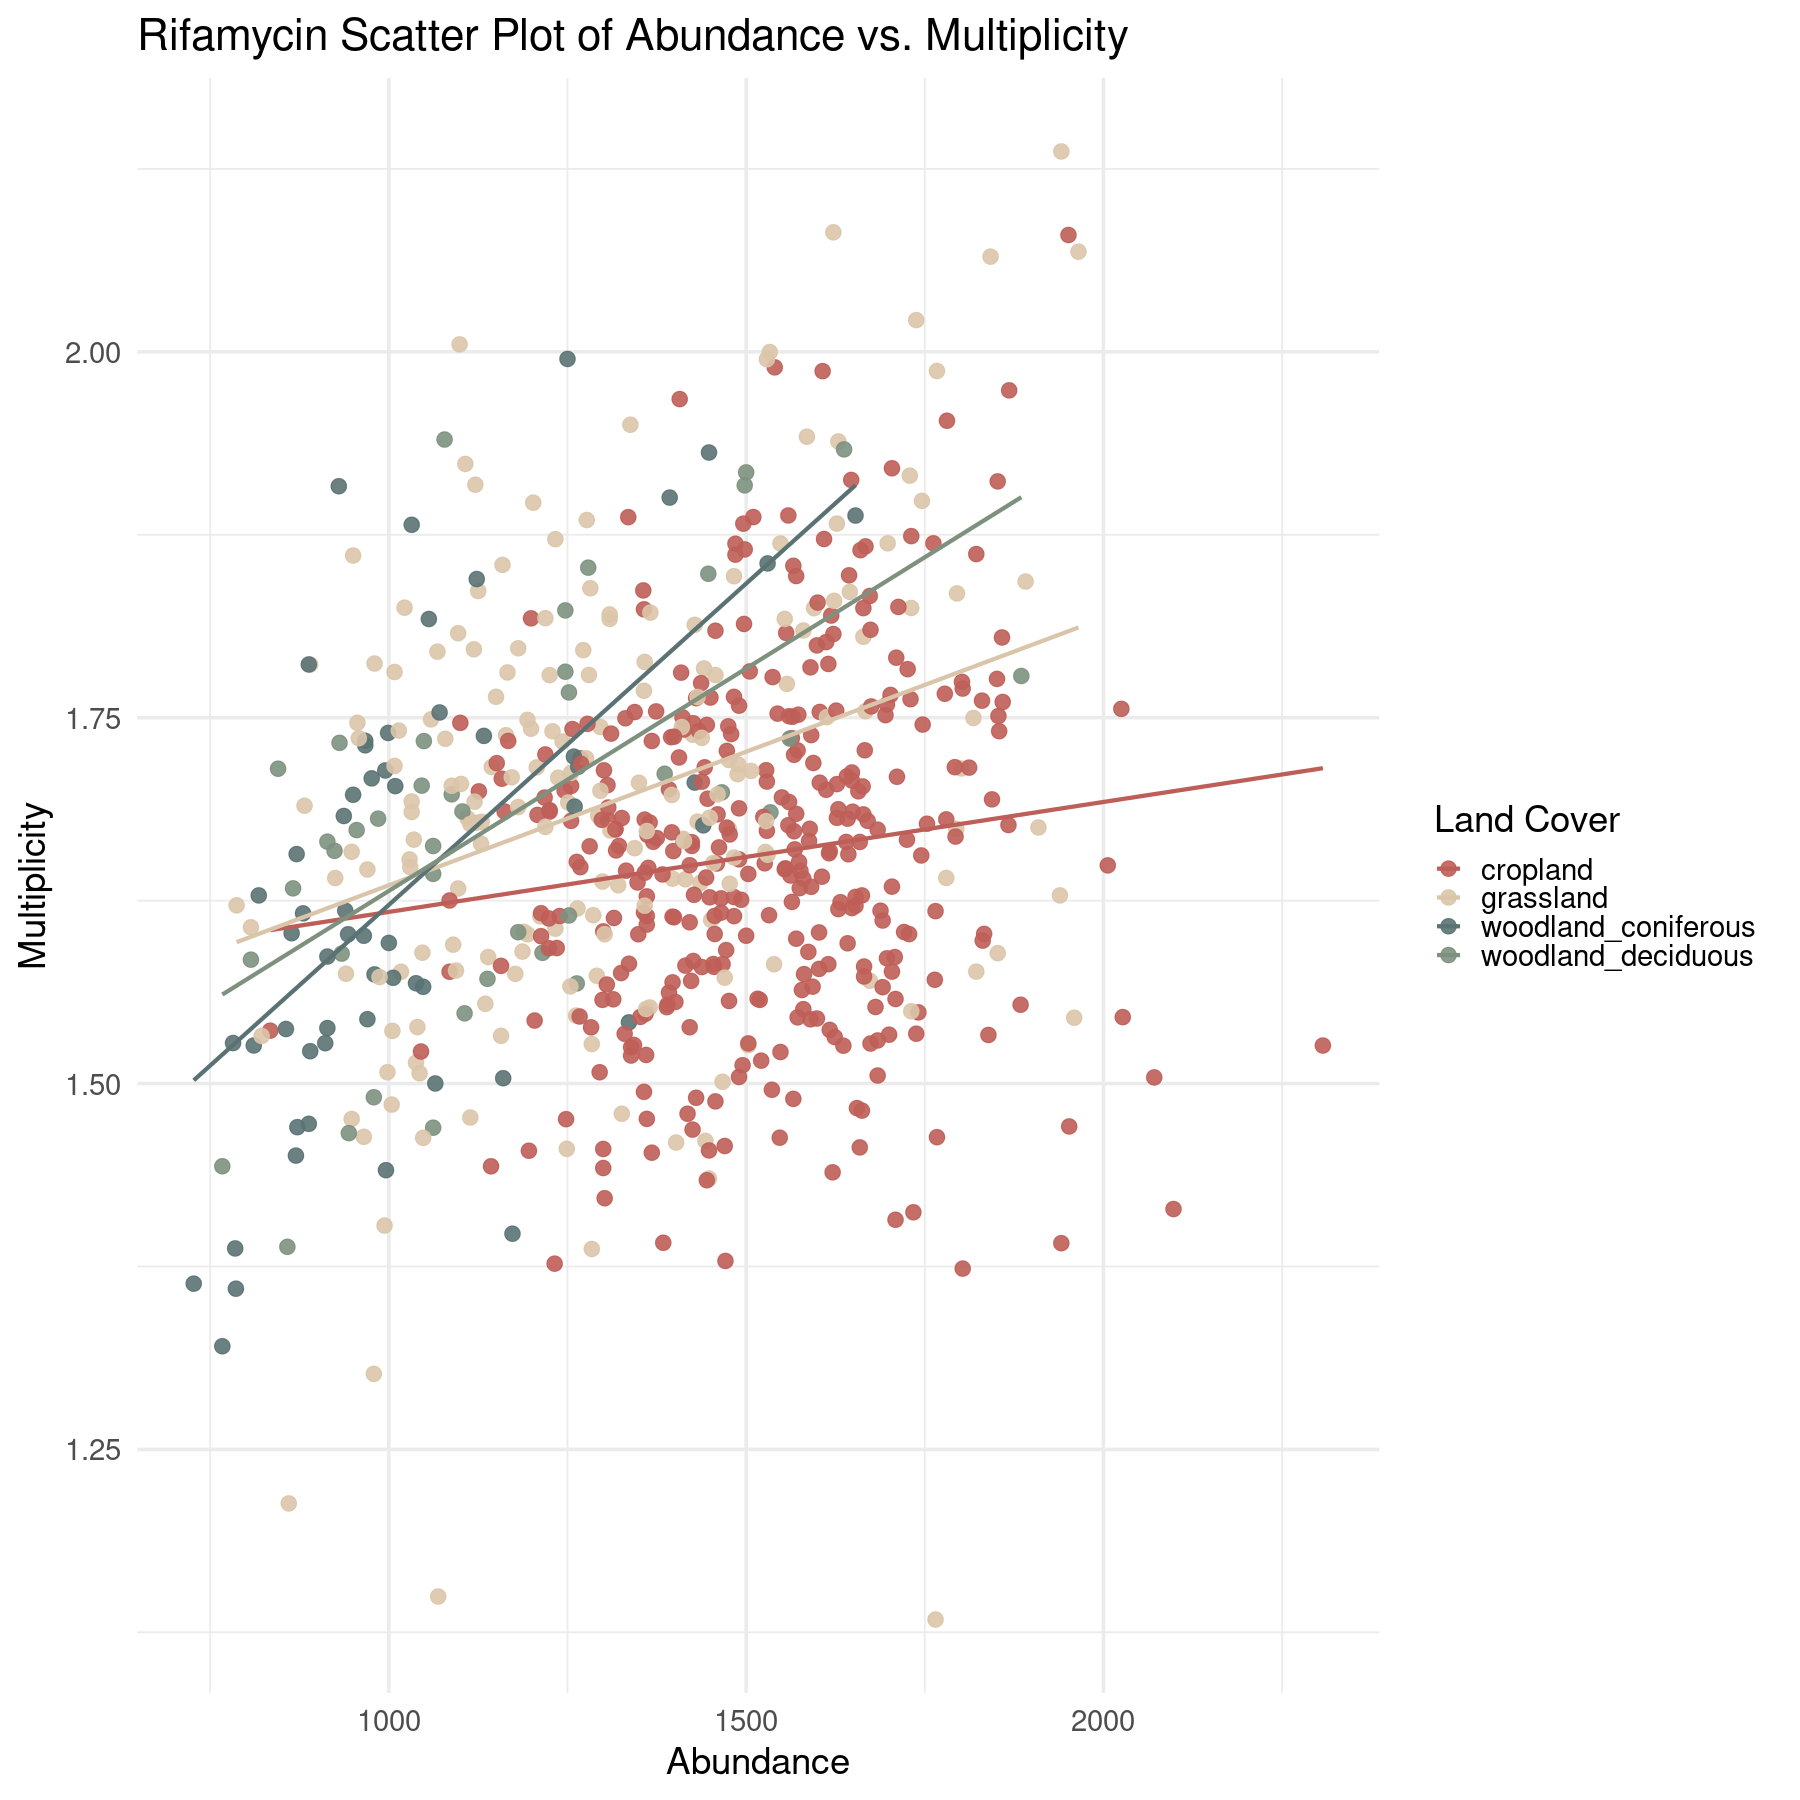

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 15)


group <- "rifamycin"


df_plot <- df_pairs %>% filter(Group %in% c(group))


# Define label mapping
label_map <- c(
  "woodland_deciduous" = "Woodland Deciduous",
  "woodland_coniferous" = "Woodland Coniferous",
  "grassland" = "Grassland",
  "cropland" = "Cropland"
)

# Define custom colors
custom_colors <- c("#BE5E58", "#DAC5AA", "#5A7273", "#7D917E")
custom_colors <- setNames(custom_colors, c("cropland", "grassland", "woodland_coniferous", "woodland_deciduous"))

# Scatter plot
ggplot(df_plot, aes(x = Abundance, y = Multiplicity, color = LandCover)) +
  geom_point(size = 4, alpha = 0.9) +  # Customize point size and transparency
      geom_smooth(method = "lm", se = FALSE, linewidth = 1.2) +  # Add regression lines without confidence interval
    scale_color_manual(values = custom_colors) +  # Apply custom colors
  labs(title = paste0(str_to_title(group), " Scatter Plot of Abundance vs. Multiplicity"),
       x = "Abundance",
       y = "Multiplicity",
       color = "Land Cover") +  # Legend title
  theme_minimal(base_size = 22)  # Use a clean themeb

`geom_smooth()` using formula = 'y ~ x'


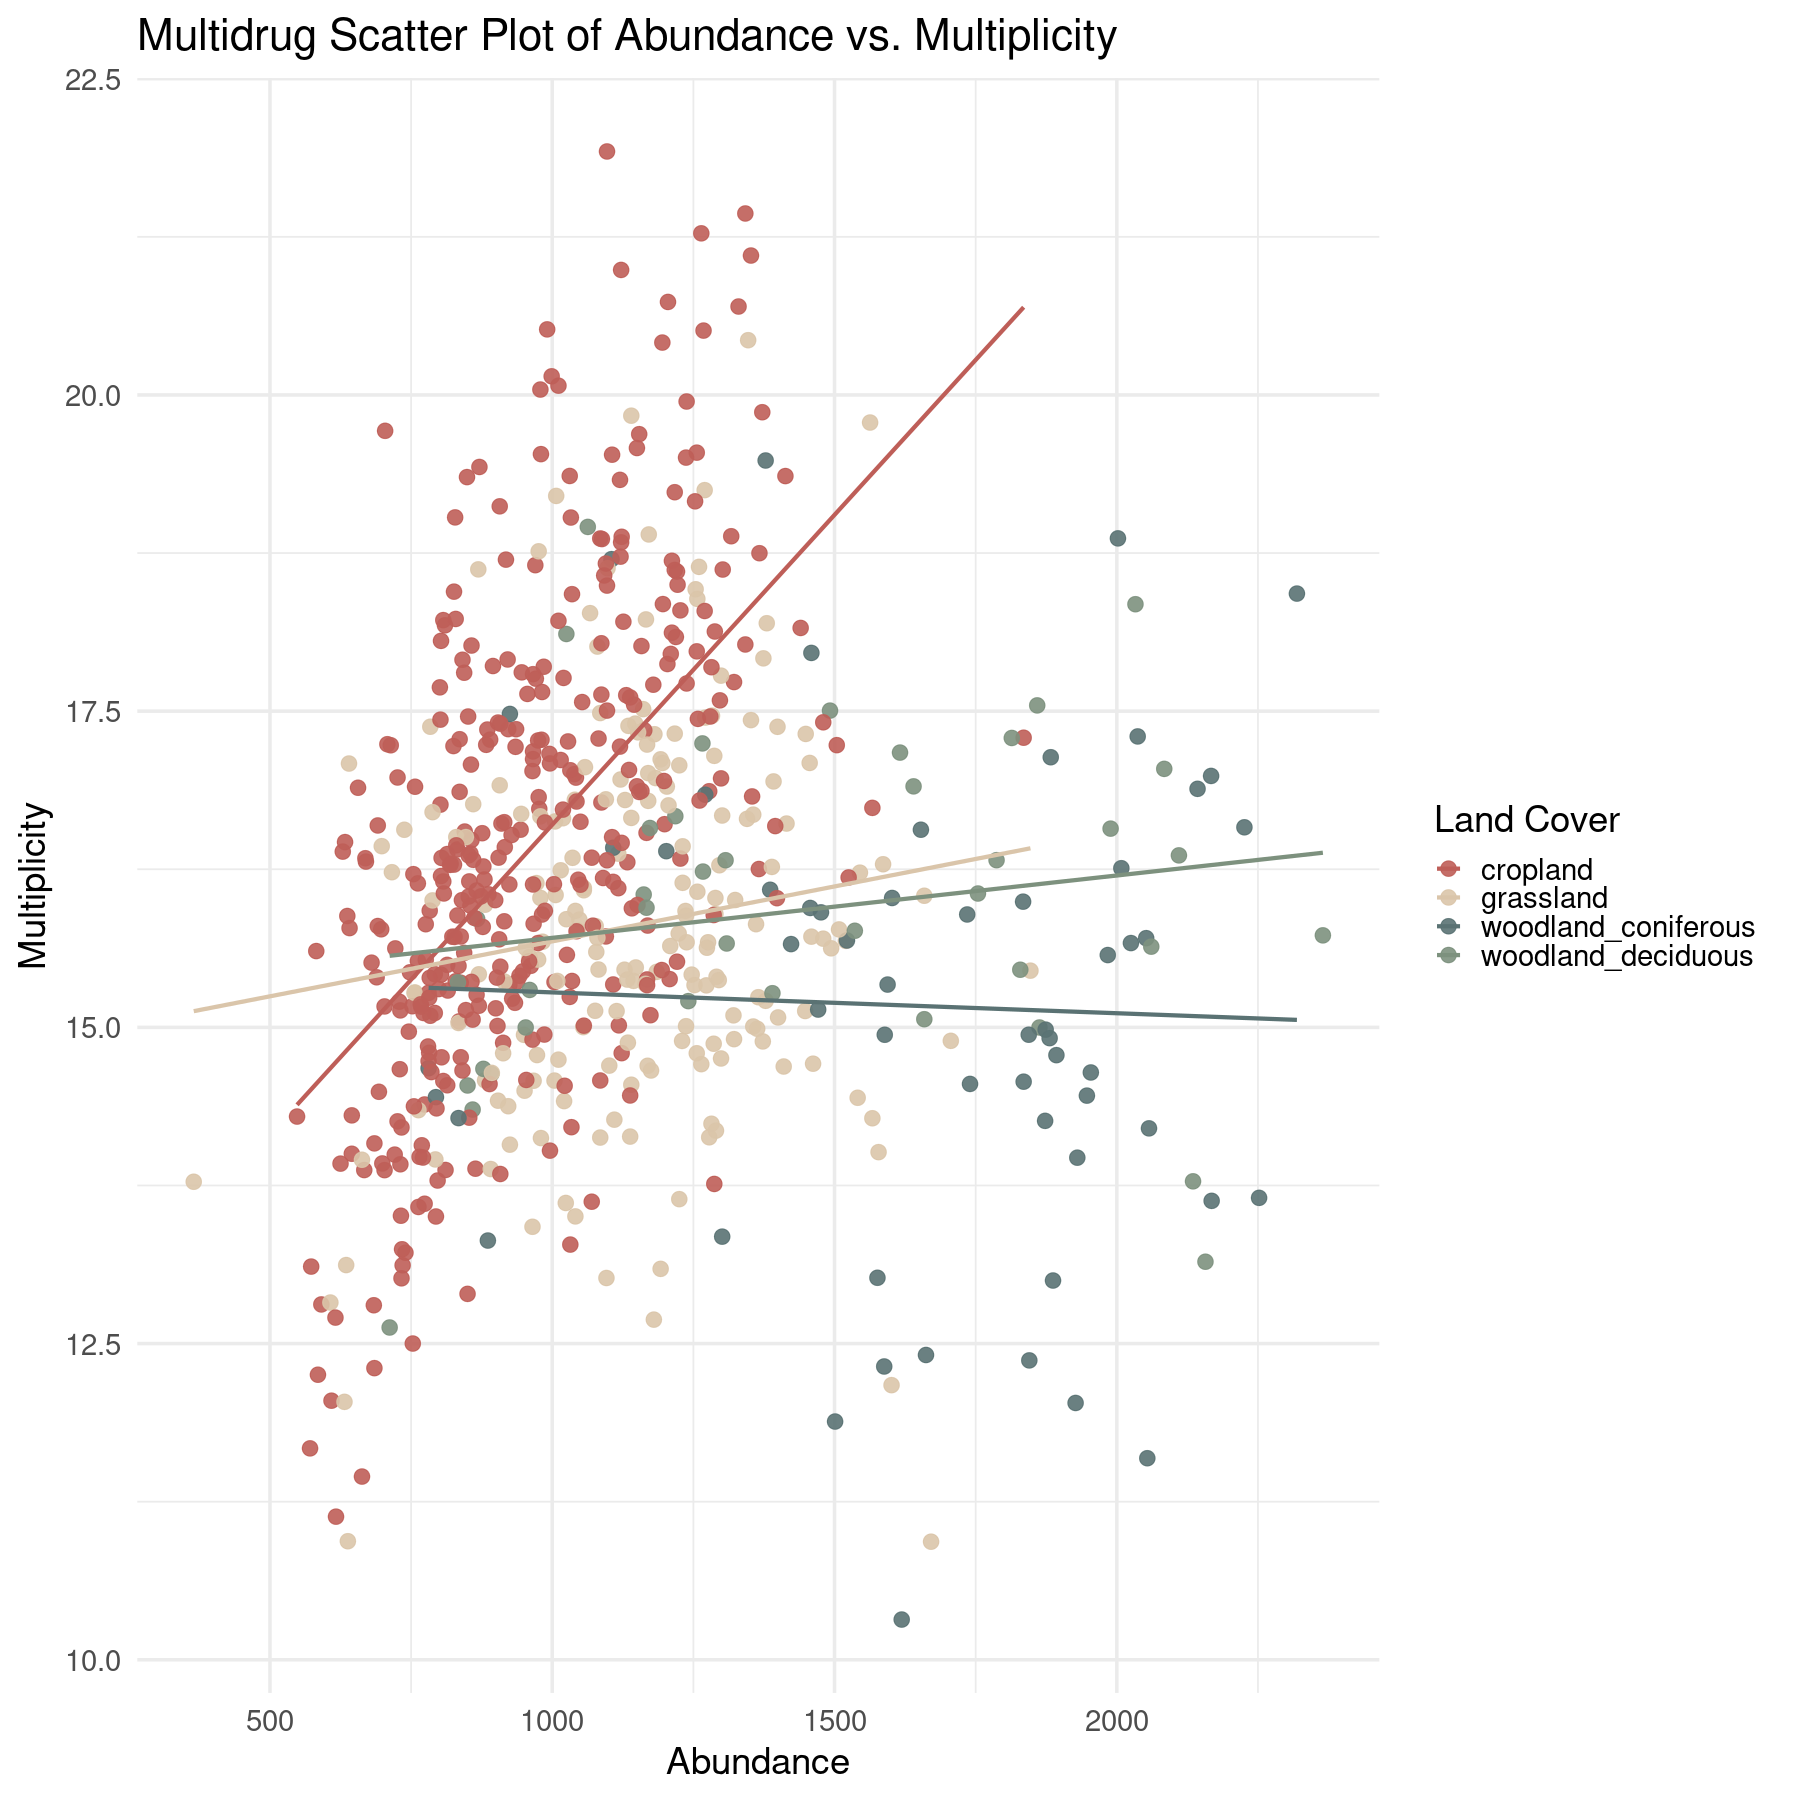

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 15)


group <- "multidrug"


df_plot <- df_pairs %>% filter(Group %in% c(group))


# Define label mapping
label_map <- c(
  "woodland_deciduous" = "Woodland Deciduous",
  "woodland_coniferous" = "Woodland Coniferous",
  "grassland" = "Grassland",
  "cropland" = "Cropland"
)

# Define custom colors
custom_colors <- c("#BE5E58", "#DAC5AA", "#5A7273", "#7D917E")
custom_colors <- setNames(custom_colors, c("cropland", "grassland", "woodland_coniferous", "woodland_deciduous"))

# Scatter plot
ggplot(df_plot, aes(x = Abundance, y = Multiplicity, color = LandCover)) +
  geom_point(size = 4, alpha = 0.9) +  # Customize point size and transparency
      geom_smooth(method = "lm", se = FALSE, linewidth = 1.2) +  # Add regression lines without confidence interval
    scale_color_manual(values = custom_colors) +  # Apply custom colors
  labs(title = paste0(str_to_title(group), " Scatter Plot of Abundance vs. Multiplicity"),
       x = "Abundance",
       y = "Multiplicity",
       color = "Land Cover") +  # Legend title
  theme_minimal(base_size = 22)  # Use a clean themeb

Joining with `by = join_by(SampleID)`


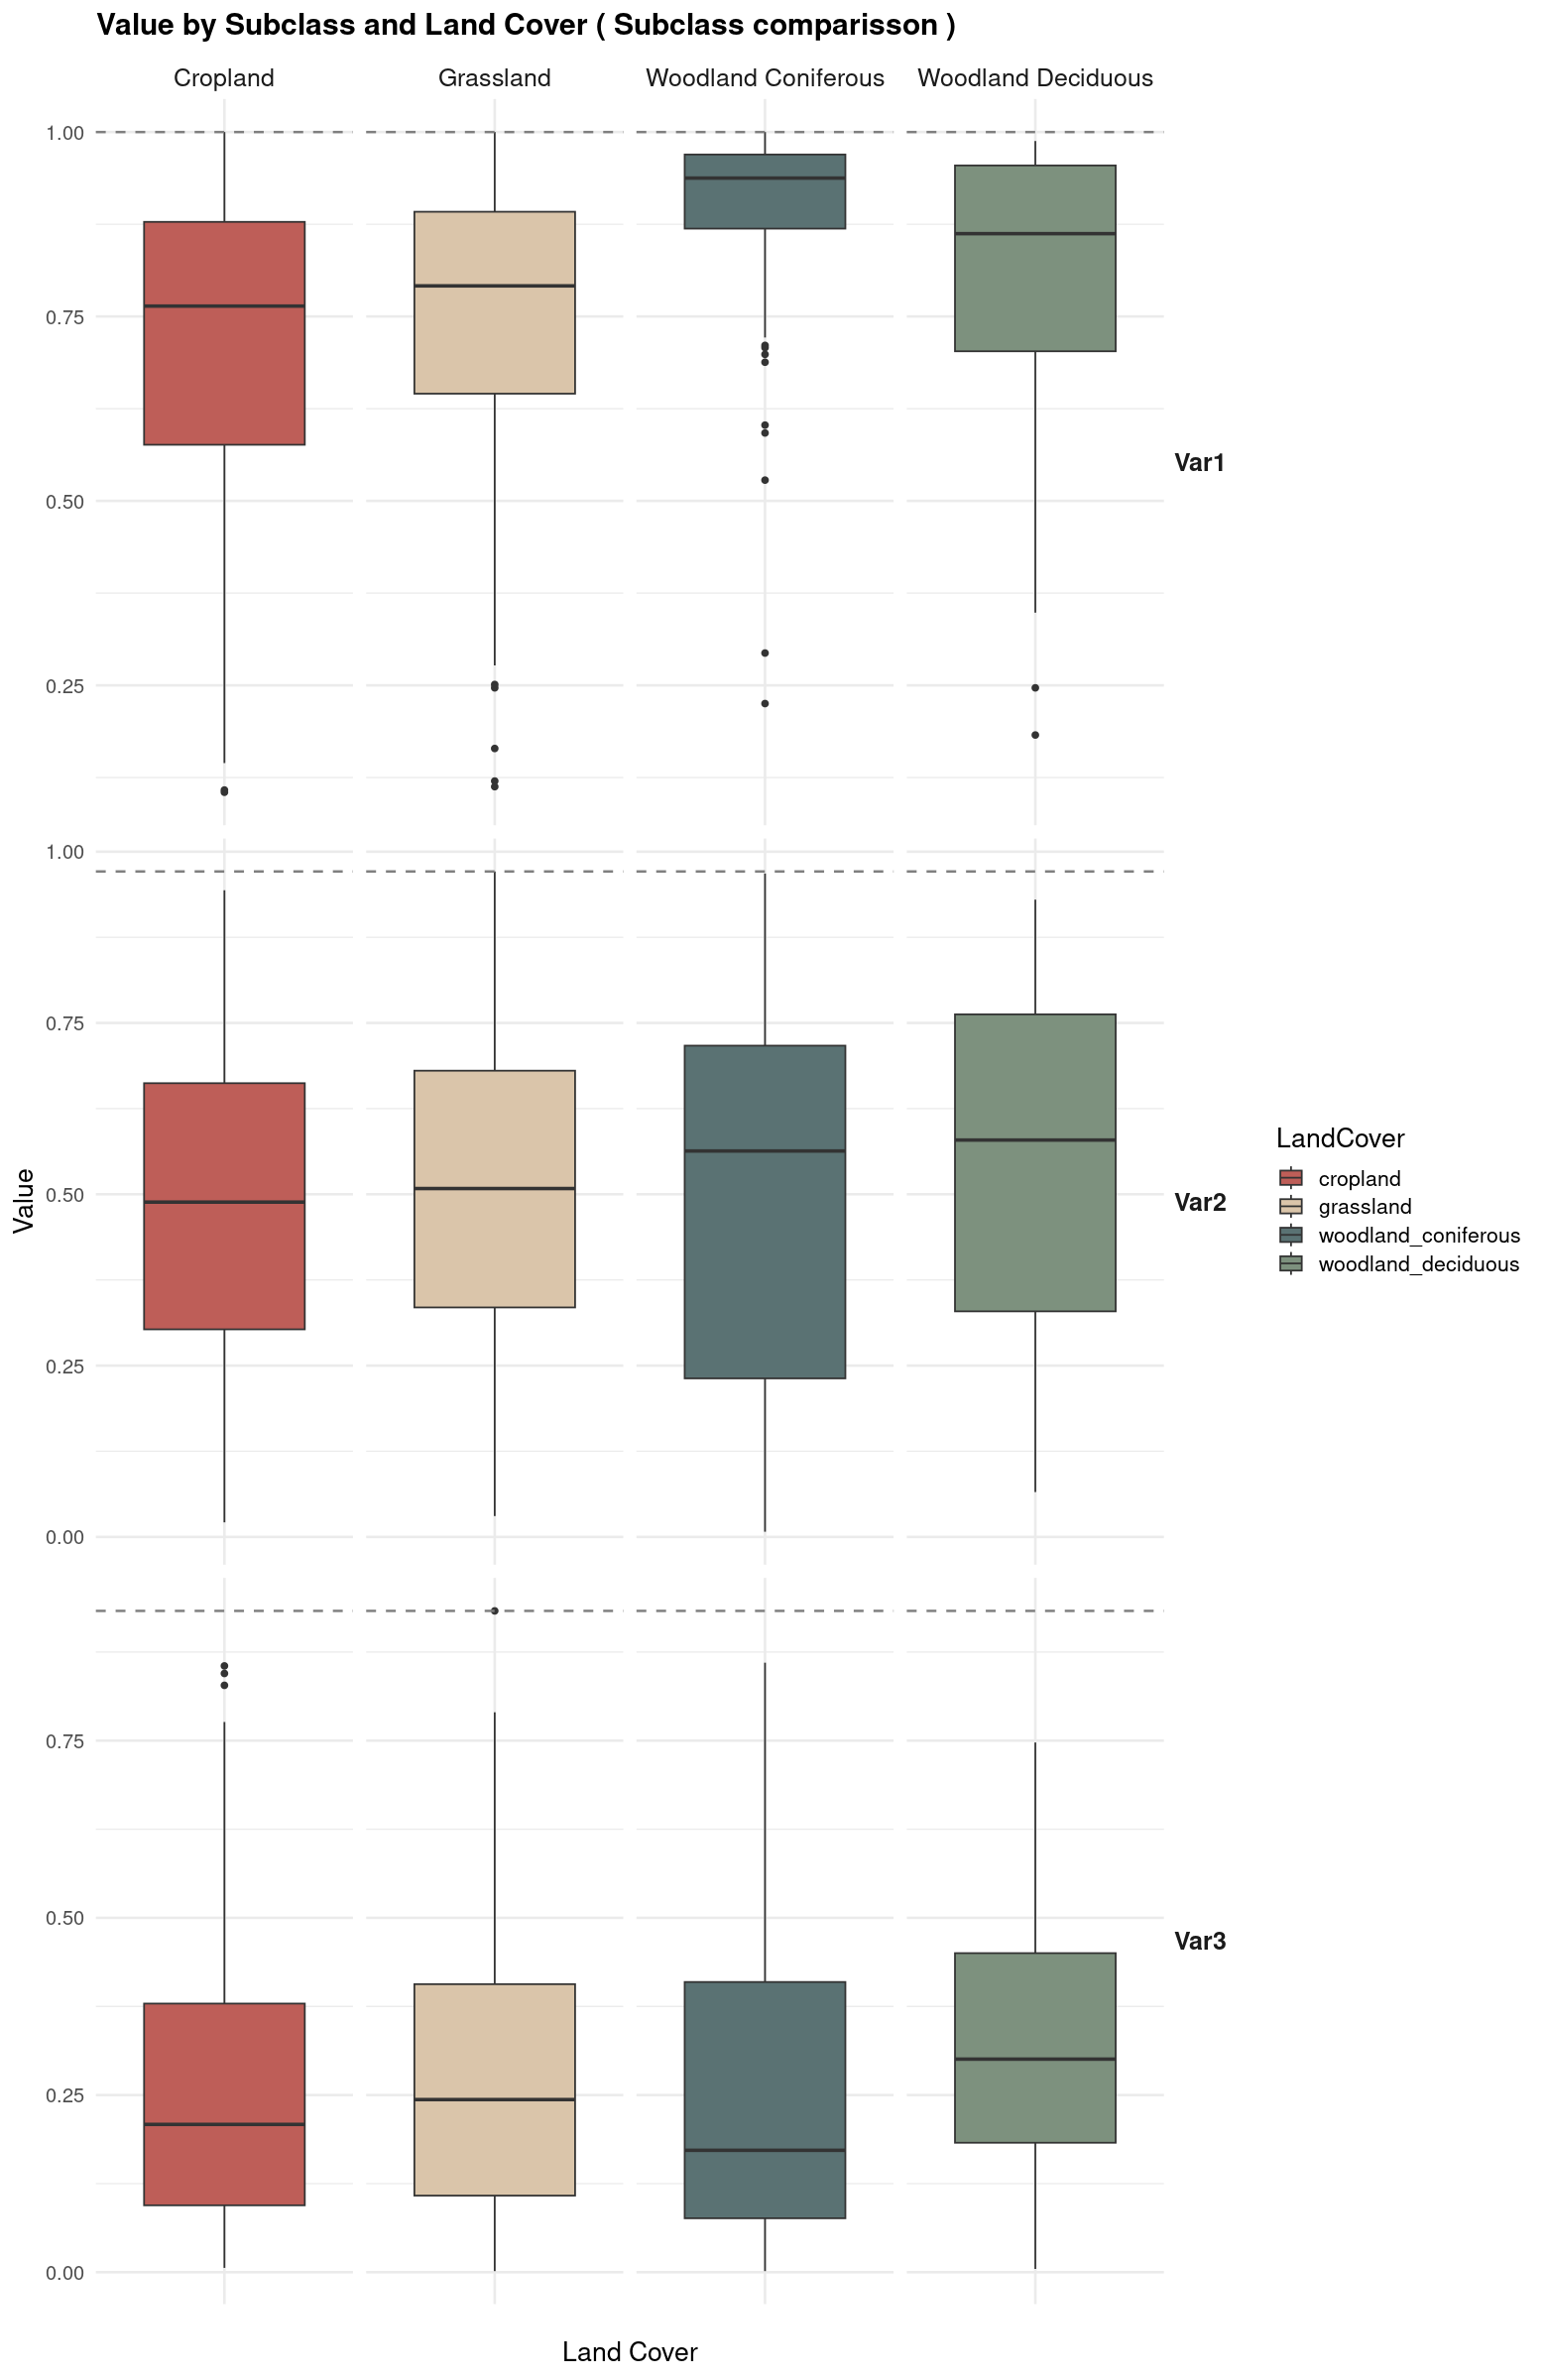

In [ ]:
library(purrr)


options(repr.plot.width = 13, repr.plot.height = 20)
ps <- list()

custom_colors <- colorRampPalette(c("white", "red"))(100)


df_crosstab <- df_filtered %>%
select(SampleID, Group, Multiplicity) %>% 
pivot_wider(names_from = Group, values_from = Multiplicity,values_fill = 0) %>%
column_to_rownames("SampleID")

for (col in names(df_crosstab)) {
    f <- ecdf(df_crosstab[, col])
    df_crosstab[, col] <- f(df_crosstab[, col]) 
}

results <- c()

for(i in 1:nrow(df_crosstab))
{
  row_name <-   rownames(df_crosstab)[i]
  results <- rbind(results, c(row_name, sort(as.vector(as.numeric(df_crosstab[i,])), decreasing = TRUE)))
}



vars  <- sapply(1:ncol(df_crosstab), function(x){paste0("Var",x)})

colnames(results)  <- c("SampleID",vars)

df_sorted <- as_tibble(results)

for(v in vars)
{
  df_sorted <- df_sorted %>% mutate(!!v := as.numeric(.data[[v]]))
}

df_sorted <- df_sorted %>%
  pivot_longer(cols = -SampleID, names_to = "Var", values_to = "Value")  %>% 
  inner_join(df_meta)



# Sorts
df_plot <- df_sorted %>%
  mutate(Var = factor(Var, levels = vars))



# Define label mapping
label_map <- c(
  "woodland_deciduous" = "Woodland Deciduous",
  "woodland_coniferous" = "Woodland Coniferous",
  "grassland" = "Grassland",
  "cropland" = "Cropland"
)

# Define custom colors
custom_colors <- c("#BE5E58", "#DAC5AA", "#5A7273", "#7D917E")
custom_colors <- setNames(custom_colors, c("cropland", "grassland", "woodland_coniferous", "woodland_deciduous"))


# Calculate horizontal line positions dynamically
hline_positions <- df_plot %>%
  group_by(Var) %>%
  summarise(y_max = max(Value), .groups = "drop") %>%
  mutate(y_sep = lead(y_max))  # Get separation lines


ggplot(df_plot, aes(x = "", y = Value, fill = LandCover)) +  # Empty x-axis for boxplots
  geom_boxplot() +
     #geom_jitter(width = 0.1, alpha = 0.25, color = "#3A3A3A") +
  geom_hline(data = hline_positions, aes(yintercept = y_max), linetype = "dashed", color = "gray50", size = 0.7, na.rm = TRUE) +
  facet_grid(Var ~ LandCover,  labeller = labeller(LandCover = label_map), scales = "free_y") +  # Create a grid layout
    scale_fill_manual(values = custom_colors) +  # Apply custom colors

  labs(x = "Land Cover", y = "Value", title = paste("Value by",target_level ,"and Land Cover (", target_level,"comparisson )")) +
    theme_minimal(base_size = 16) +  # Increase text size
  theme(
    strip.text = element_text(size = 15),  # Larger facet labels
    axis.text = element_text(size = 12),   # Larger axis labels
    strip.text.y = element_text(size = 15, face = "bold", angle = 0, hjust = 0),  # Rotate labels horizontally
    plot.title = element_text(size = 18, face = "bold"))  # Bigger title



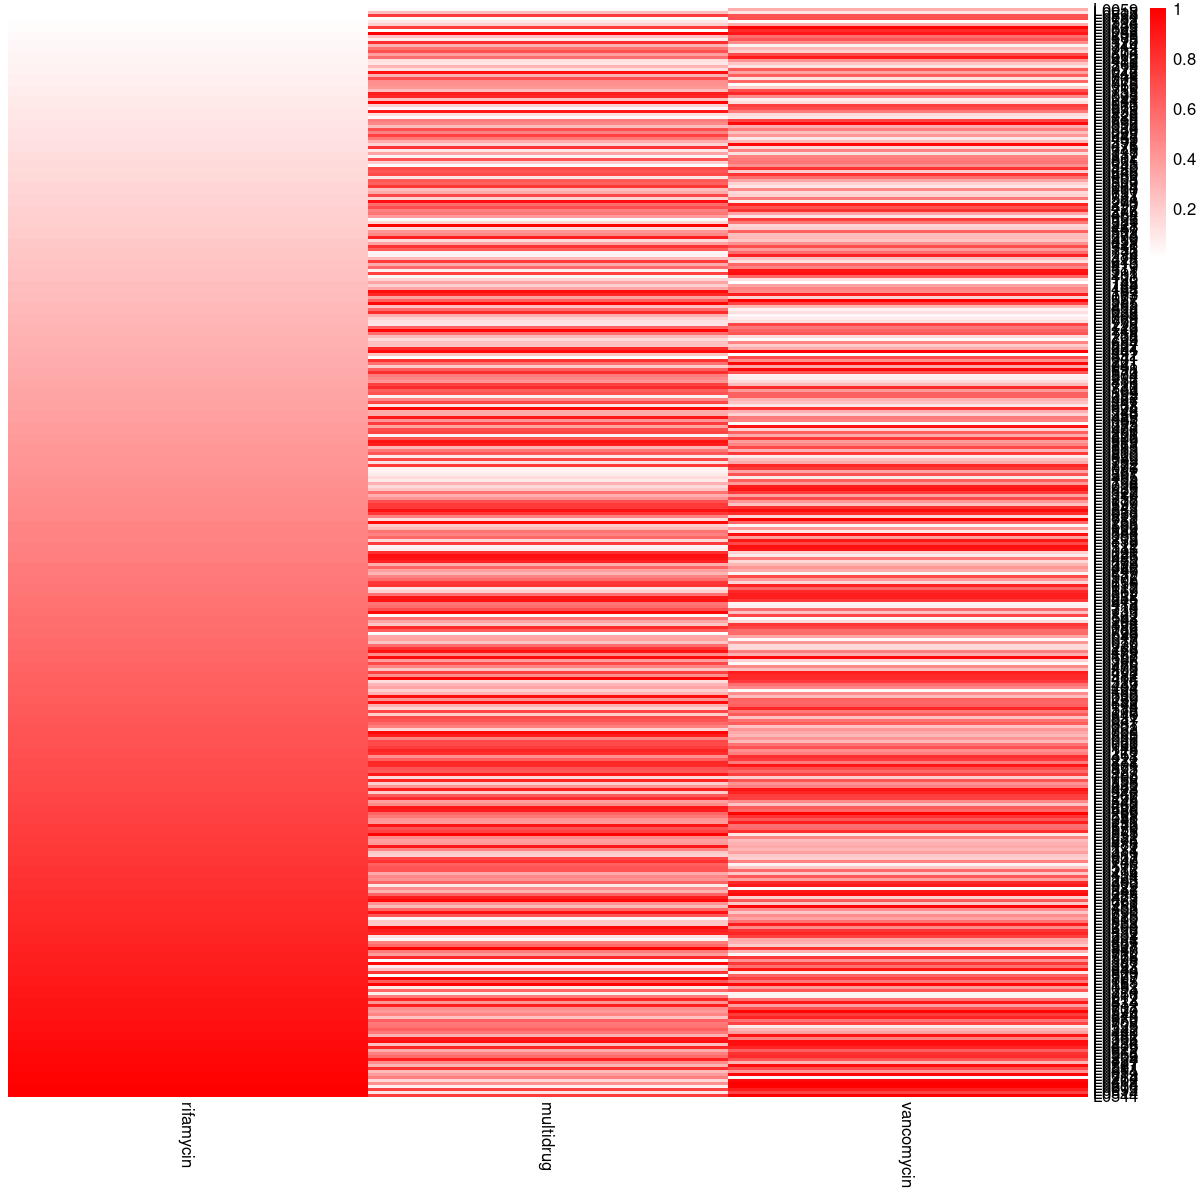

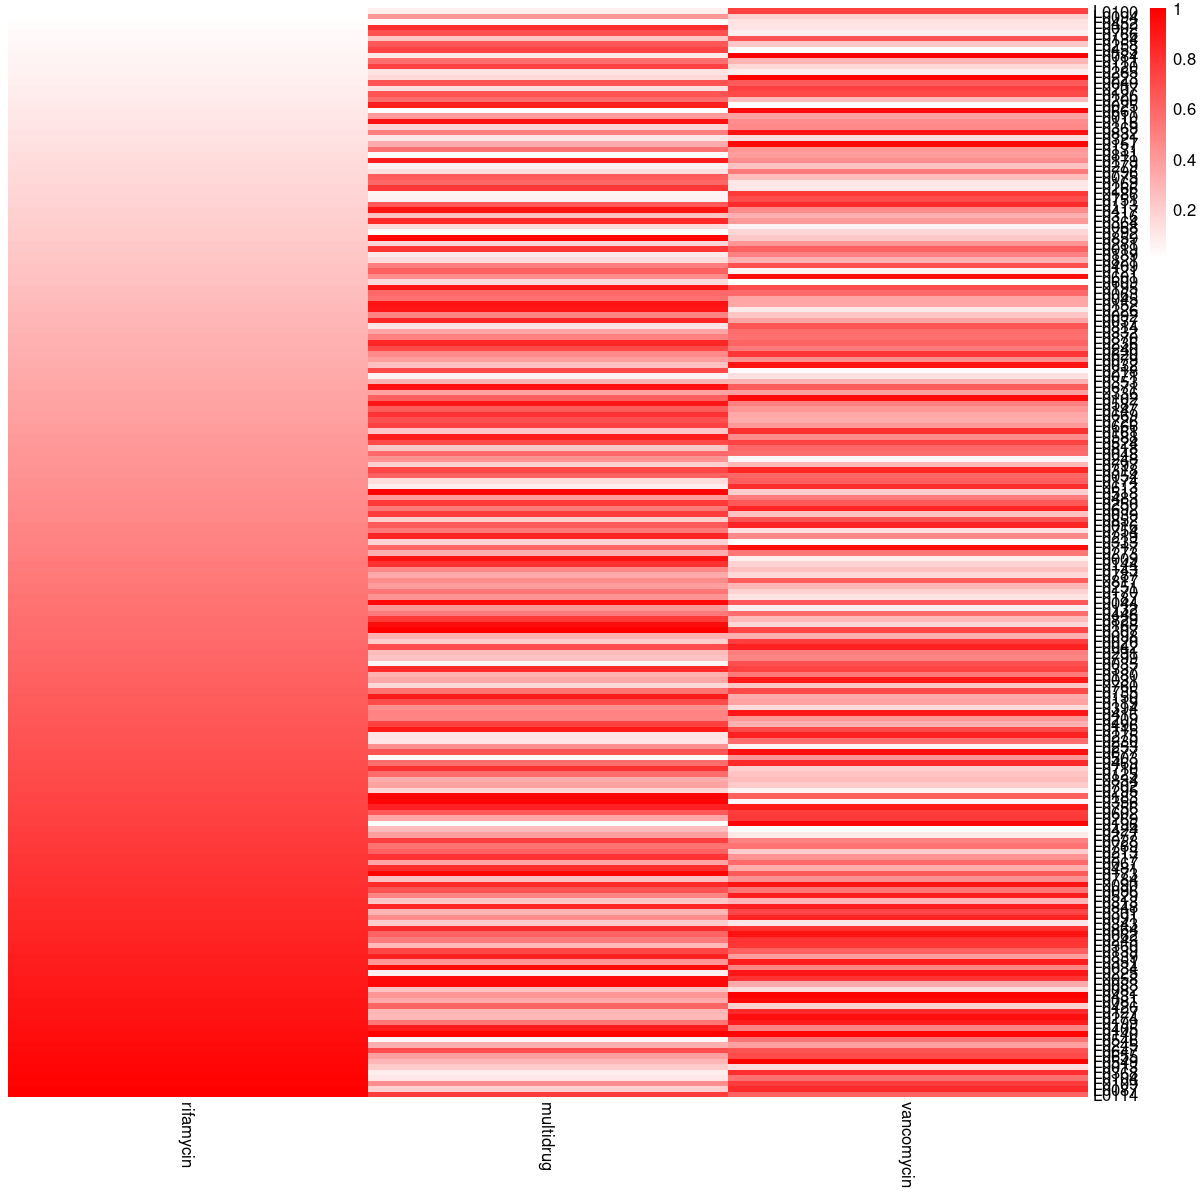

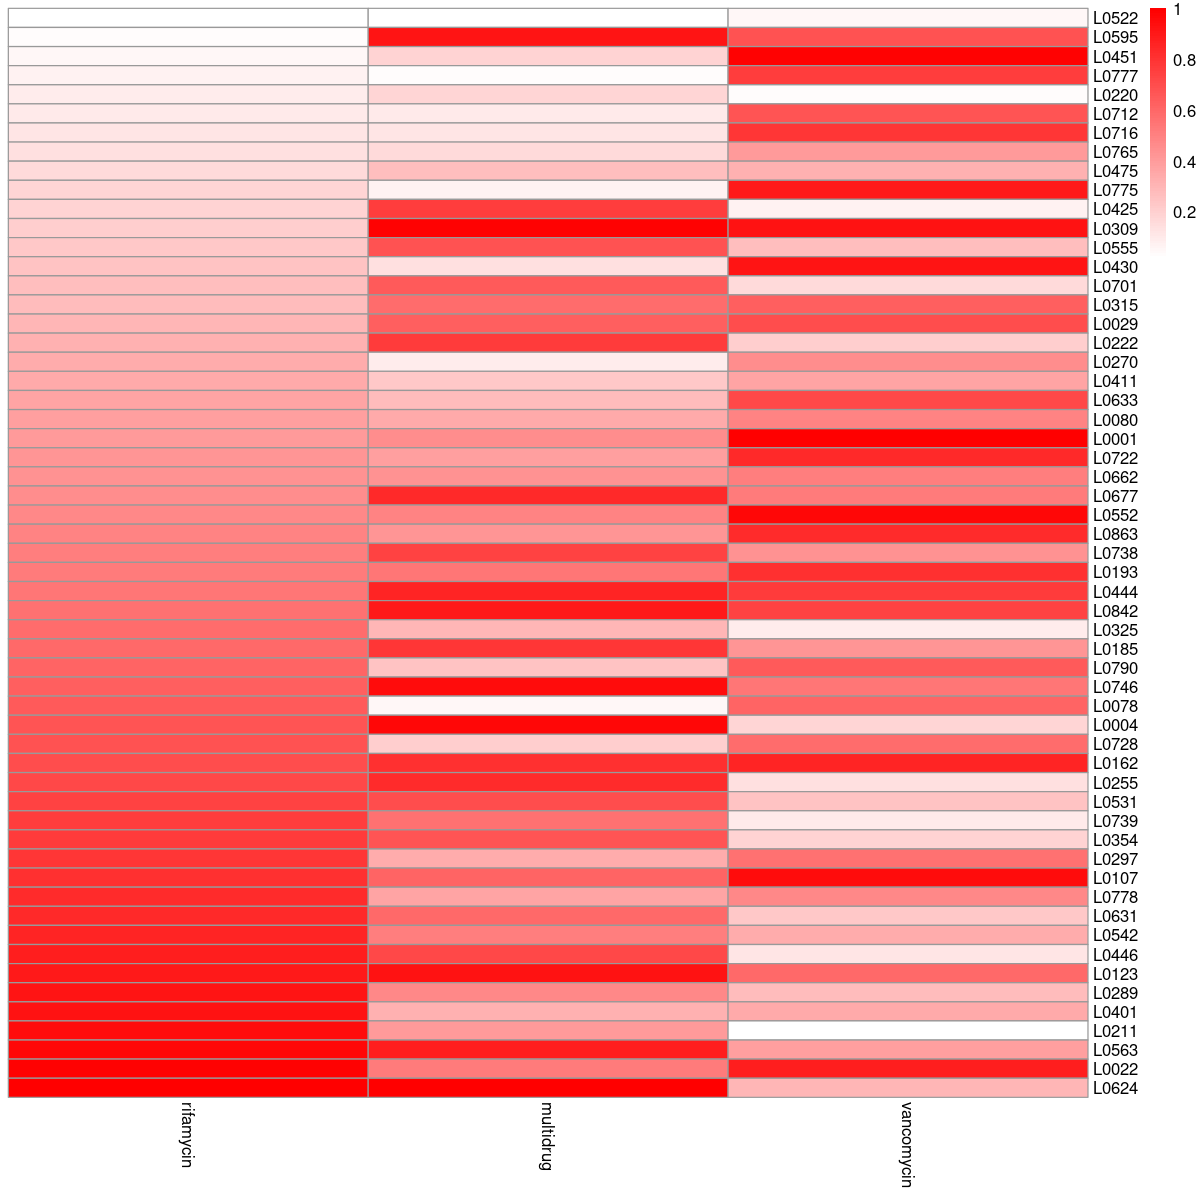

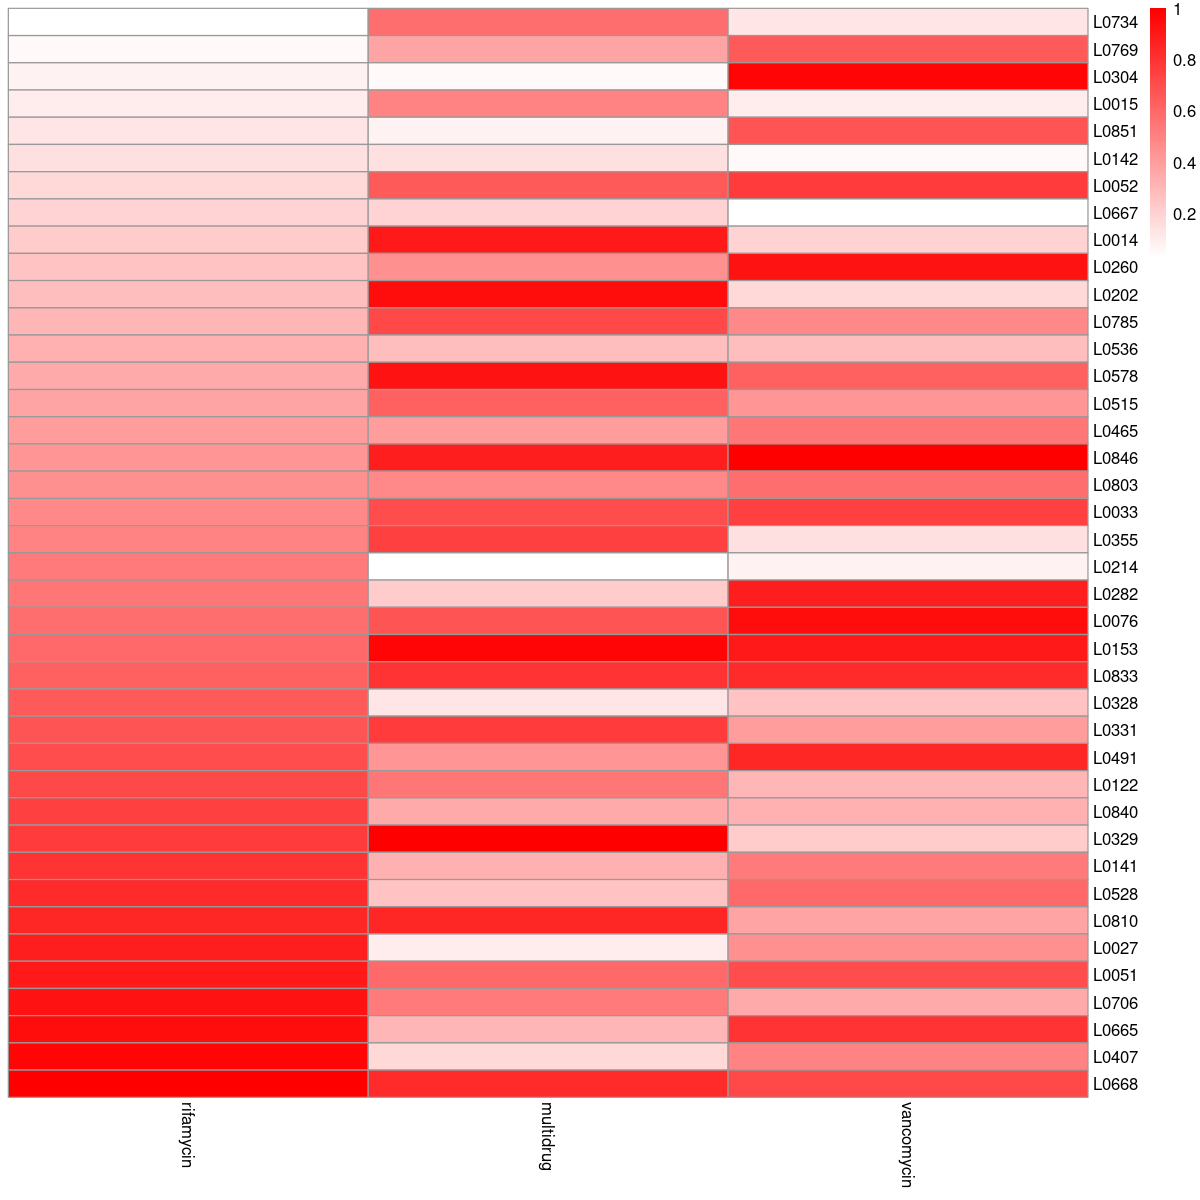

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)
ps <- list()

custom_colors <- colorRampPalette(c("white", "red"))(100)

for(lc in c("cropland", "grassland", "woodland_coniferous", "woodland_deciduous"))
{

  df_crosstab <- df_filtered %>%
  filter(LandCover == lc) %>% 
  select(SampleID, Group, Multiplicity) %>% 
    pivot_wider(names_from = Group, values_from = Multiplicity,values_fill = 0) %>%
    column_to_rownames("SampleID")

    for (col in names(df_crosstab)) {
      f <- ecdf(df_crosstab[, col])
      df_crosstab[, col] <- f(df_crosstab[, col]) 
    }

    df_crosstab  <- df_crosstab  %>% arrange(across(everything()))

  ps[[length(ps)+1]] = pheatmap(df_crosstab, scale = "none", cluster_rows = FALSE, cluster_cols = FALSE, color = custom_colors)
}



In [ ]:
write.csv(df, "multiplicity_by_gene.csv", row.names = FALSE)